<h1 style='color:orange; font-weight:bold; text-align:center'>Optimizing Ride Fares: A Dynamic Pricing Model for Ride-Sharing Services</h1>

## **1 Introduction**
### **1.1 Context**
Dynamic pricing is a strategy where price is adaptively adjusted according to various factors, including market demand. For instance, during peak hours or holiday seasons, the price of a service may increase to balance the high demand. Unlike static pricing, dynamic approach allows the company to optimize revenue and manage demand more effectively. However, without careful considerations, dynamic pricing can pose a danger to a business. When not configured carefully, not only can dynamic pricing gives uncertainty to the customers, especially when setting the price can go too high or too low, non-strategic pricing can lead to reducing customer retention or making the services less attractive to potential customers. Customers who avoid paying more, for example, will look for other ride-sharing providers or wait for the normal pricing. To maintain balance between profitability and retaining/attracting customers, therefore, dnamic pricing should be carefully considered.

A ride-sharing company currently aims to implement a dynamic pricing model (ML-based dynamic pricing) where the fare of the daily pass adapts to different factors so that the company can generate higher profit during high demands and still maintain profitability during low demands. This ML-based dynamic pricing is expected to quickly respond to volatile conditions.

### **1.2 Problem Statement**
Now ride fares are mainly determined by using ride duration which does not account for fluctuating demand or supply imbalances. This rule-based approach can lead to inefficiencies and reduced profitability because this rule-based pricing is only optimized for one factor while in practice, there is an interplay between factors such as time of booking, customer's location, and available drivers. The ride-sharing company is exploring dynamic pricing strategies to adapt the fares of their daily pass to improve profitability.

### **1.3 Objective**
My objective is to develop a dynamic pricing model adjusting fares based on real-time factors to maximize the company's revenue. This will involve building and evaluatiing a regression model (or "regressor" for short) to predict optimal fare adjustments. Since the focus here is a development of a pricing model, insights from an exploratory data analysis in this project will concentrated more on informing the predictive model preparation rather than on business.

### **1.4 Metrics**
As the model is designed to optimize fares based on real-time conditions, a misprediction of the model can be either under or overestimation, particularly if excessive, of the fares, resulting in business impacts in relation to revenue, satisfaction, and reputation. On one hand, underestimation occurs when the model predicts fares lower than it should be, causing increased demand and missing out on potential revenue. On the other hand, overestimation can deter potential customers, and hence, leading to lower ride volume and reduced revenue. 
To simulate the financial impacts of the misprediction by the model, let us see the following hypothetical scenario using Divvy's data for an illustration purpose.
- **Underestimation of cost**: If the model underestimates the fare by USD0.50 on average, and there are 533K per month (average of 2022 ride data, [Chicago Tribune, 2024](https://www.chicagotribune.com/2023/06/30/divvy-bikes-hit-the-streets-of-chicago-10-years-ago-the-decade-has-been-filled-with-changes-and-challenges/#:~:text=Total%20Divvy%20rides%20each%20month%20from%202013%20to%202023&Trends%20show%20that%20ridership%20peaks,growth%20over%20the%20last%20decade.&And%20much%20of%20that%20growth,see%20ridership%20totals%20each%20year.)), the monthly revenue loss will be approximately USD266.5K. 
- **Overestimation of cost**: If the regression model overprices customers, there will be reduction in the sharing demand since the high service cost can deter potential customers. If the model makes errors by 5% per month, there will be 26.65K customers who gets overpricing. When we multiply this number of customers with Divvy's daily pass at USD 18.10 ([Divvy, 2024](https://divvybikes.com/pricing)), it means the ride sharing company will lose approximately USD 482.3K per month. And for the record, while Divvy offers bike ride sharing services and the service types of current company in this project are not specified to bikes, Divvy's fares can still be an illustration of how much the dynamic pricing model will cost when it under or overstimate the fares.

Based on these two conditions, the relevant metrics to evaluate machine learning model's predictions are R-squared ($R^2$), Mean Absolute Error, and Root Mean Squared Error.
- **Coefficient of determination** ($R^2$): It represents the proportion of variance in the target variable explained by the features. This ML metric provides a general overview of the model fit, helping us understand the explanatory power of the model.
$$R^2=1-\frac{\sum_i(y_i-\hat{y}_i)^2}{\sum_i(y_i-\bar{y})^2}$$
- **Mean Absolute Error** (MAE): It measures the average absolute difference between predicted ($\hat{y}_i$) and actual values ($y_i$), enabling us to evaluate the average magnitude of errors made by the model. The lower score of MAE indicates that the model is a better fit to the data.
$$\text{MAE} = \frac{1}{n}\sum_{i=1}^n|y_i - \hat{y}_i|$$
- **Root Mean Squared Error** (RMSE): It measures the average squared difference between predicted ($\hat{y}_i$) and actual prices ($y_i$). In its interpretation, the lower RMSE score of a model, the better the model fits to the data.
$$\text{RMSE}=\sqrt{\frac{1}{n}\sum_{i=1}^1(y_i-\hat{y_1})^2}$$

### **1.5 Dataset**
The dataset was obtained from [Möbius](https://www.kaggle.com/datasets/arashnic/dynamic-pricing-dataset/data) on Kaggle. In general, the dataset contains 10 variables (listed below). And one variable, namely `Historical_Cost_of_Ride` will become the target variable for the dynamic pricing model.
- `Number_of_Riders`: Number of customers who use the sharing service (int)
- `Number_of_Drivers`: Available supply of drivers
- `Location_Category`: Geographical area where the ride is requested.
- `Customer_Loyalty_Status`: Membership type, e.g., silver or gold
- `Average_Ratings`: Average satisfaction score given by the customer
- `Time_of_Booking`: Time of the day when the ride is booked
- `Vehicle_Type`: Type of vehicle requested
- `Expected_Ride_Duration`: Estimated duration of the ride
- `Historical_Cost_of_Ride`: Previous cost

In [2]:
# Data Exploration
import phik
import numpy as np
import pandas as pd
import seaborn as sns
import ptitprince as pt
import statsmodels.api as sm
from scipy.stats import kruskal
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import skew, kurtosis, kstest, shapiro 
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Preprocessing
from sklearn.compose import ColumnTransformer
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression

# Machine Learning
import shap
import joblib
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import learning_curve
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

# Misc
import time
import session_info
plt.style.use('ggplot')
pd.options.display.max_colwidth = 50

## **2 Data Understanding**
In this section, my aim is to find out the overview of the data in terms of sanity. Each answer of the questions will provide an understanding what treatment I should give to the data to avoid introducing errors in the machine learning model's predictions. Not only model's predictions become biased or not trustworthy, but inferential statistical tests can also give an invalid conclusions.
- how many numerical and categorical variables
- how many duplicates are
- whether there are any missing values
- whether the distributions of the numerical variables are normal
- whether the dataset suffers from high cardinality and rarity
- whether there are any measurement errors, and 
- whether there are any incorrect data types.

### **2.1 General data overview**
To begin with, I will build a function to inspect a dataframe. This function is useful when later checking a dataframe is done repetitively. Furthermore, with respect to some insights I need to find out above, I will need the function to inform me the number of variables based on their data types, the number of observations (rows), the number of missing values, the number of duplicates, and some examples of the variable.

In [3]:
# create function to inspect df
def inspect_dataframe(df):
    print(f'The dataframe contains {df.shape[0]} rows and {df.shape[1]} cols.')
    print(f"- {len(df.select_dtypes(include='number').columns)} are numeric cols")
    print(f"- {len(df.select_dtypes(include='O').columns)} are object cols")
    summary = {
        'ColumnName': df.columns.values.tolist(),
        'Nrow': df.shape[0],
        'DataType': df.dtypes.values.tolist(),
        'NAPct': (df.isna().mean() * 100).round(2).tolist(),
        'DuplicatePct': (df.duplicated().sum()/len(df)*100).round(2),
        'UniqueValue': df.nunique().tolist(),
        'Sample': [df[col].unique() for col in df.columns]
    }
    return pd.DataFrame(summary)

In [4]:
# load dataset
df = pd.read_csv('../data/dynamic_pricing.csv')

# remove underscore in colnames
df.columns = df.columns.str.replace('_', '')

# inspect dataframe
inspect_dataframe(df)

The dataframe contains 1000 rows and 10 cols.
- 6 are numeric cols
- 4 are object cols


,ColumnName,Nrow,DataType,NAPct,DuplicatePct,UniqueValue,Sample
0,NumberofRiders,1000,int64,0.0,0.0,81,"[90, 58, 42, 89, 78, 59, 93, 62, 79, 86, 60, 2..."
1,NumberofDrivers,1000,int64,0.0,0.0,79,"[45, 39, 31, 28, 22, 35, 43, 14, 6, 17, 38, 8,..."
2,LocationCategory,1000,object,0.0,0.0,3,"[Urban, Suburban, Rural]"
3,CustomerLoyaltyStatus,1000,object,0.0,0.0,3,"[Silver, Regular, Gold]"
4,NumberofPastRides,1000,int64,0.0,0.0,101,"[13, 72, 0, 67, 74, 83, 44, 71, 21, 99, 15, 50..."
5,AverageRatings,1000,float64,0.0,0.0,151,"[4.47, 4.06, 3.99, 4.31, 3.77, 3.51, 4.41, 3.5..."
6,TimeofBooking,1000,object,0.0,0.0,4,"[Night, Evening, Afternoon, Morning]"
7,VehicleType,1000,object,0.0,0.0,2,"[Premium, Economy]"
8,ExpectedRideDuration,1000,int64,0.0,0.0,171,"[90, 43, 76, 134, 149, 128, 16, 47, 167, 144, ..."
9,HistoricalCostofRide,1000,float64,0.0,0.0,1000,"[284.25727302188227, 173.87475274940766, 329.7..."


**Note**
- The dataset contains 10 features, consisting of 6 numerical features (`NumberofRiders`, `NumberofDrivers`, `NumberofPastRides`, `ExpectedRideDuration`, and `HistoricalCostofRide`) and 4 categorical ones (`LocationCategory`, `CustomerLoyaltyStatus`, `TimeofBooking`, and `VehicleType`). For the numerical features, as some have large values, rescaling will be required to prevent one or more features predominating others during the machine learning training. The effect of this predomination is that the features can greatly affect the model's prediction since the model will prioritize the large values. And for the categorical ones, I will transform them into numerical values so that they can be processed by the model. However, which type of scaling and encoding should be done remains an open question here since I do not have enough information yet about the numerical and the categorical features.
- The data size is relatively small (*N* = 1,000). Decision on what amount of data should be the training set will later become crucial.
- In addition to data types, the dataset is clean enough. It does not contain any missing values, duplicates, and high cardinality. While there are no cardinality shown here, a further check must be carried out to see if there are any rare values in the categorical features. The rare values can introduce potential bias to the machine learning model. For example, the model will prioritize the frequent values over the rare ones during the predictions.

### **2.2 Is every variable normally distributed?**
Checking data distribution is not only critical for statistical tests, especially the inferential ones, but also for machine learning. In machine learning, non-normally distributed data affects feature scaling. For instance, if the data for a specific feature does not follow Gaussian distribution (bell-shaped curve), using standard scaler or min-max scaler will not be optimal because they are greatly affected by extreme values. Moreover, some models such as linear regressions or Gaussian Naive Bayes assume normality of distribution. While the models may still make predictions on the skewed distribution, their predictions may be less accurate.

Testing whether the numerical features follow normal distributions or not, I will firstly need some descriptive statistics such as min, max, and quantiles (Q1, Q2, and Q3). These metrics can give me a sense of spread of data numerically.

In [5]:
# check distribution of data numerically
df.select_dtypes(include='number').describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
NumberofRiders,1000.0,60.37,23.70,20.00,40.00,60.00,81.00,100.00
NumberofDrivers,1000.0,27.08,19.07,5.00,11.00,22.00,38.00,89.00
NumberofPastRides,1000.0,50.03,29.31,0.00,25.00,51.00,75.00,100.00
AverageRatings,1000.0,4.26,0.44,3.50,3.87,4.27,4.63,5.00
ExpectedRideDuration,1000.0,99.59,49.17,10.00,59.75,102.00,143.00,180.00
HistoricalCostofRide,1000.0,372.50,187.16,25.99,221.37,362.02,510.50,836.12


**Note**
- At glance, `HistoricalCostofDrive` appears to have outliers since the values at the 3rd quantile is far from the max value at 836.12.
- However, this result is not a guarantee that this feature do contains outliers and outliers in other numerical features are absent. To make sure, I will perform another test on outliers using interquartile range (IQR).
- But because this section is concerned with data distribution, I will focus more on testing the distributions numerically and visually. Both tests are needed because they can complement each other. While the numerical test can quantify the distribution characteristics, the visual test can quickly reveal shape of the distribution and the presence of outliers. Combining these tests, therefore, can provide a more comprehensive understanding for a decision making about the next step.

In [6]:
# check data distribution
df_numeric = (df.select_dtypes(include='number'))
ks_pvalues = df_numeric.apply(lambda col: kstest(col, 'norm')[1]).values
sw_h = df_numeric.apply(lambda col: shapiro(col)[0]).values
sw_values = df_numeric.apply(lambda col: shapiro(col)[1]).values

# display output in df
pd.DataFrame({
    'column': df_numeric.columns,
    'skewness': df_numeric.apply(skew).round(4).values,
    'kurtosis': df_numeric.apply(kurtosis).round(4).values,
    'statistic': sw_h.round(4),
    'pvalue': sw_values.round(4),
    'decision': ['H0 rejected' if p < 0.05 else 'H0 accepted' for p in sw_values]
})

,column,skewness,kurtosis,statistic,pvalue,decision
0,NumberofRiders,0.0022,-1.2223,0.9510,0.0,H0 rejected
1,NumberofDrivers,0.9618,0.1263,0.8994,0.0,H0 rejected
2,NumberofPastRides,-0.0084,-1.2129,0.9531,0.0,H0 rejected
3,AverageRatings,-0.0786,-1.1710,0.9543,0.0,H0 rejected
4,ExpectedRideDuration,-0.1397,-1.1533,0.9549,0.0,H0 rejected
5,HistoricalCostofRide,0.2093,-0.7795,0.9799,0.0,H0 rejected


**Note**
- In the code above, I utlitize skew, kurtosis, and Shapiro-Wilk *W* test.
    - Skew measures the symmetry of a distribution. Zero skewness means that the distribution is symmetric while positive or negative skewness suggest the presence of longer tail on either right or left size (Field, Field, & Miles, 2012).
    - Kurtosis checks peakedness of a distribution. A normal distribition is characterized numerically by mesokurtic (not high and not low peak) (Field, Field, & Miles, 2012).
    - Shapiro-Wilk test is a statistical test to determine whether a sample data comes from a normally distributed population. If the probability value is less than 0.05, the null hypothesis of normality is rejected (meaning that the data is not normally distributed). But if greater than 0.05, the null hypothesis can be accepted.
- As can be seen on the dataframe output above, all numerical features indicate non-normal distributions based on the *p*-values (hereby $H_0$ is rejected) but their skewness and kurtosis values are closer to zero, meaning that while their distributions are not normal, theirs are close to the center of the distribution.

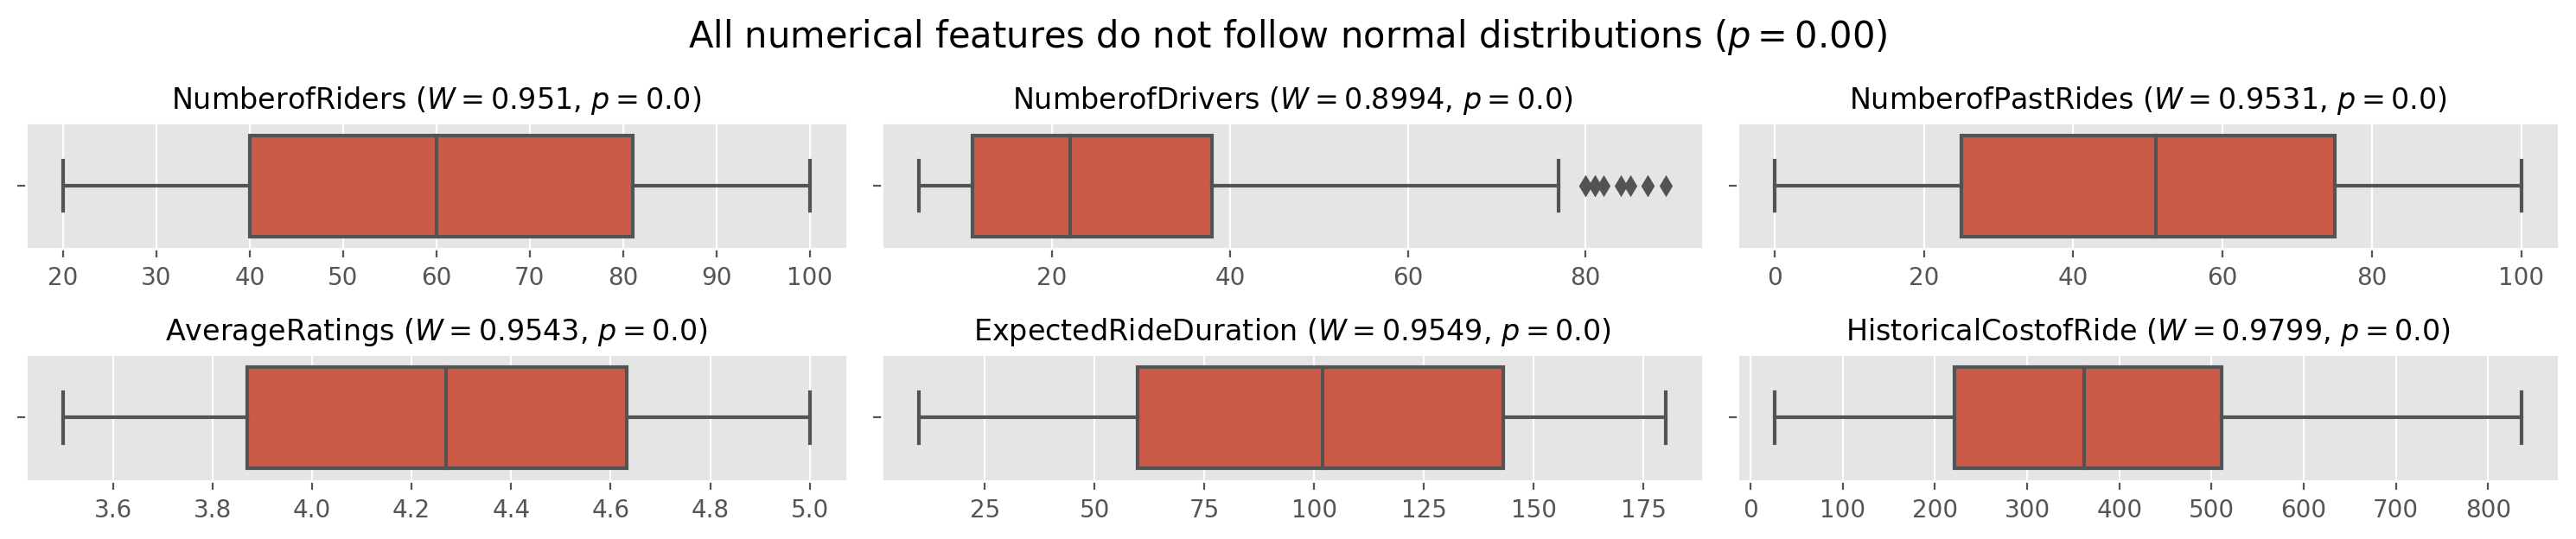

In [7]:
# compute SW test
shapiro_results = df_numeric.apply(lambda col: shapiro(col))
stats_df = pd.DataFrame({
    'column': df_numeric.columns,
    'sw_statistic': df_numeric.apply(lambda col: shapiro(col)[0]).values.round(4),
    'sw_pvalues': df_numeric.apply(lambda col: shapiro(col)[1]).values.round(4)
})

# display boxplots
plt.figure(figsize=(15, 7), dpi=200)
for i, col in enumerate(df_numeric.columns):
    plt.subplot(5, 3, i+1)
    sns.boxplot(x=df[col])
    # sns.stripplot(x=df[col], color='k', alpha=0.2, jitter=True)
    # locate H stat and p-val
    row = stats_df[stats_df['column'] == col]
    statistic = row['sw_statistic'].values[0]
    p_value = row['sw_pvalues'].values[0]
    plt.title(f'{col} ($W = {statistic}$, $p = {p_value}$)', size=12)
    plt.xlabel(None)
plt.suptitle('All numerical features do not follow normal distributions ($p = 0.00$)', size=15)
plt.tight_layout()
plt.show()

**Note**
- The visual test help me confirm the numerical test results that while the distributions are all not normal, the spreads are closer to the center. If the assumption test was only done by using visual one, it might be tempting to say that the numerical features generally have normal distribution, except for `NumberOfDrivers`.
- In addition to this confirmation, the visual test enables me to quickly investigate whether there are outliers present in the dataset. As shown, only do feature `NumbeofDrivers` contain outliers.
- The implication of the outliers is that if linear regression (linear model) or k-nearest neighbor (distance-based model) will be used among different models in the experiments, these outliers will affect the model's predictions, leading an error such as overestimation or underestimation.
- These outliers can be handled by rescaling features with a requirement of robustness towards outliers. For this reason, robust scaler can be a main option.

### **2.3 Are there any outliers in the dataset?**
As informed previously on the normal distribution test, outliers are present only in `NumberofDrivers`. This part is a follow-up on the distribution check. This will not only confirm whether there are outliers but also quantify the number of the outliers. The number of outliers is important since higher number of outliers can significantly affect the data distribution. This check can also guide which treatment in the data preprocessing pipeline should be considered.

$$IQR = Q3 - Q1$$
$$\text{lower threshold} = Q1 - 1.5 \times IQR$$
$$\text{upper threshold} = Q3 + 1.5 \times IQR$$

In [8]:
# create function to detect outliers using IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df.loc[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"The number of outliers in '{column}' is {len(outliers)} or {(len(outliers)/len(df)*100):.2f}% of the total data ({len(df)} rows).")

In [9]:
# apply function to detect outliers
for i in df_numeric:
    detect_outliers(df, i)

The number of outliers in 'NumberofRiders' is 0 or 0.00% of the total data (1000 rows).
The number of outliers in 'NumberofDrivers' is 10 or 1.00% of the total data (1000 rows).
The number of outliers in 'NumberofPastRides' is 0 or 0.00% of the total data (1000 rows).
The number of outliers in 'AverageRatings' is 0 or 0.00% of the total data (1000 rows).
The number of outliers in 'ExpectedRideDuration' is 0 or 0.00% of the total data (1000 rows).
The number of outliers in 'HistoricalCostofRide' is 0 or 0.00% of the total data (1000 rows).


**Note**
- Similar to the boxplots shown in the previous section, there is only one feature containing outliers, namely `NumberofDrivers` (*N* = 10 or 1% of the total data). Since there is only a small number of outliers, they can be removed, wisorized, or rescaled. And as mentioned above, robust scaling can be an option.
- While removal or winsorization can be performed, the small sample size should be the main consideration. Removing instances containing outliers can decrease the sample size, and therefore, removal is not a good option here. Winsorization, on the other hand, can be an alternative option for robust scaling. 
- One consideration for moving forward with robust scaling is the fact that even if winsorization is done to this numerical feature, this feature will later be rescaled in order all numerical features to have the similar value ranges. For efficiency, it is possible to directly rescale this feature along with other numerical features with no outliers. The rescaling technique which can minimize the impacts of outliers is robust scaling.
- This scaling technique is more robust to outliers compared to standard scaling or min-max scaling because this technique does not use the mean, min, or max value of the feature. Instead, it uses the median and interquartile range of the feature.
$$X_{\text{scaled}} = \frac{X - X_{\text{median}}}{Q3-Q1}$$

### **2.4 Are there any rare categories?**
While in Section 2.1 cardinality has been checked and there were no features with high cardinality found, the previous result has not told whether the categorical features have rare values or not. Here, my intention is to explore whether there are rare categories or not by using an arbitrary threshold at 0.01 (1%). Below 1%, the categories will be detected as rare, and hence, a treatment should be given. The treatment here is usually converting rare categories with other less frequent categories as "Others". Merging these categories will prevent the model from making biased prediction to the more frequent categories.

In [10]:
# count unique values in each var
pd.DataFrame({
    'ColumnName': df.select_dtypes(include='O').columns.values.tolist(),
    'Nrow': df.select_dtypes(include='O').shape[0],
    'UniqueValue': df.select_dtypes(include='O').nunique().tolist(),
})

,ColumnName,Nrow,UniqueValue
0,LocationCategory,1000,3
1,CustomerLoyaltyStatus,1000,3
2,TimeofBooking,1000,4
3,VehicleType,1000,2


In [11]:
# check rare labels using threshold at 1%
rare_labels = {column: (df[column].value_counts() < (0.01 * len(df))).sum() 
               for column in df.select_dtypes(include=['object']).columns}

# display output in df
pd.DataFrame(rare_labels, index=[0])

,LocationCategory,CustomerLoyaltyStatus,TimeofBooking,VehicleType
0,0,0,0,0


**Note**: Operationalizing rare labels for the occurrence of categorical values under 1%, there are no rare labels found. For this reason, no treatment will be necessary.

### **2.5 Are there any signs of multicolinearity?**
Multicollinearity occurs when two or more features have strong correlations. When the predictors are multicorrelated, determining an independent contribution of each predictor to the target (`HistoricalCostofRide`) will become a challenge since the correlated features share explanatory power.

Commonly, multicollinearity can be detected in two ways: correlation coefficient and variance inflation factor (VIF). 
- Correlation: When the correlation coefficient between features are strong (closer to either -1 or 1), this indicates a potential multicollinearity. One main drawback of this diagnostic test is that correlation is pairwise test so complex multicollinearity involving three or more features cannot be detected. 
- Variance inflation factor (VIF): It can detect complex multicollinearity and quantify the multicollinearity. Generally, the threshold of a feature is considered high VIF is when the value is greater than 5. 

#### **2.5.1 Multicollinearity detection via correlation coefficient**
Section 2.2 informed that the distribution of numerical features are non-normal so correlation test to use here is Spearman's test. However, it is important to acknowledge the inherent limitation of this correlation test: Spearman's rho can only take numerical inputs. For this reason, categorical features should be tested using another correlation test.

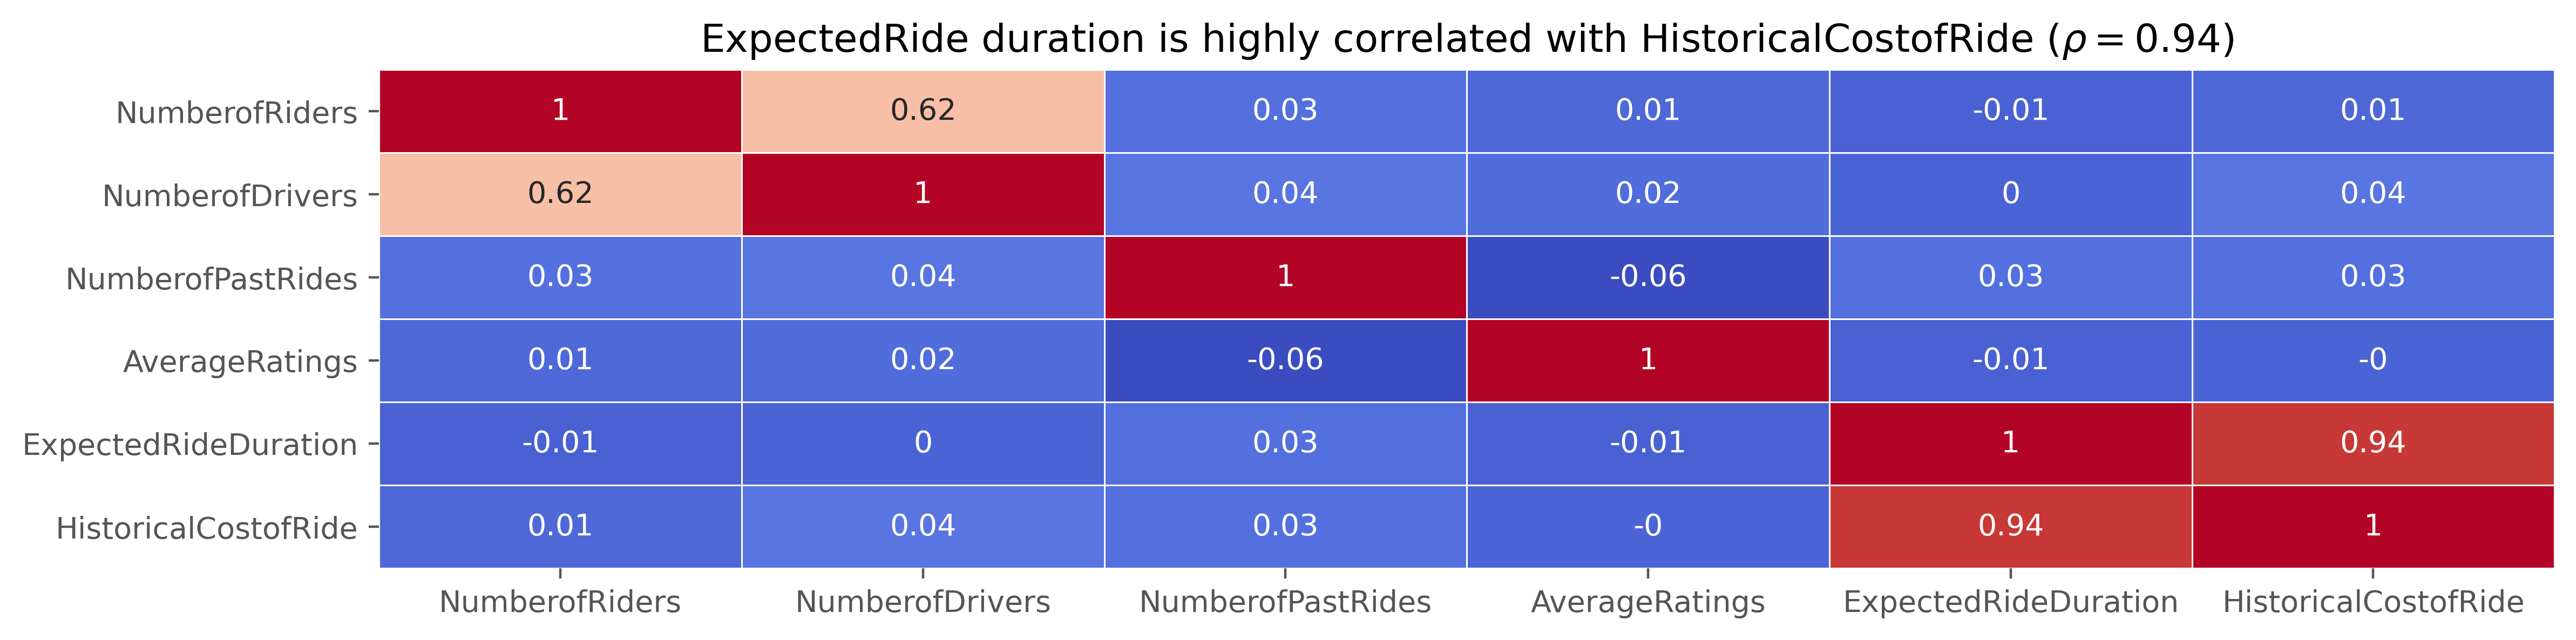

In [12]:
# build spearman correlation matrix
plt.figure(figsize=(13, 3), dpi=400)
correlation_matrix = df.select_dtypes(include='number').corr(numeric_only=True, method='spearman').round(2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, cbar=False)
plt.title('ExpectedRide duration is highly correlated with HistoricalCostofRide ($\\rho = 0.94$)', loc='center', fontsize=13)
plt.show()

**Note**
- As informed earlier, the distribution of the data is not normal so rather than using Pearson's correlation coefficient ($r$), I will use Spearman's $\rho$, a correlation test which does not assume normality of distribution.
- As can be shown, the NumberofDrivers and NumberofRiders are highly correlatred ($\rho$ = 0.62), indicating a potential multicollinearity. For this reason, one of the two variables can be excluded from the modeling phase. However, whether to exclude or include one of these two predictors from the modeling phase should be at least confirmed by the variance inflated factor (VIF) test. If the VIF value is greater than the common threshold at 5, then excluding one of the two factor can be proceed.
- While ExpectedRideDuration and HistoricalCostofRide have almost perfect correlation coefficient, their correlation value can be ignored since `HistoricalCostofRide` is the target variable. A high correlation between the predictor (`ExpectedRideDuration`) and the target indicates that the feature is potentially a strong predictor of `HistoricalCostofRide`.

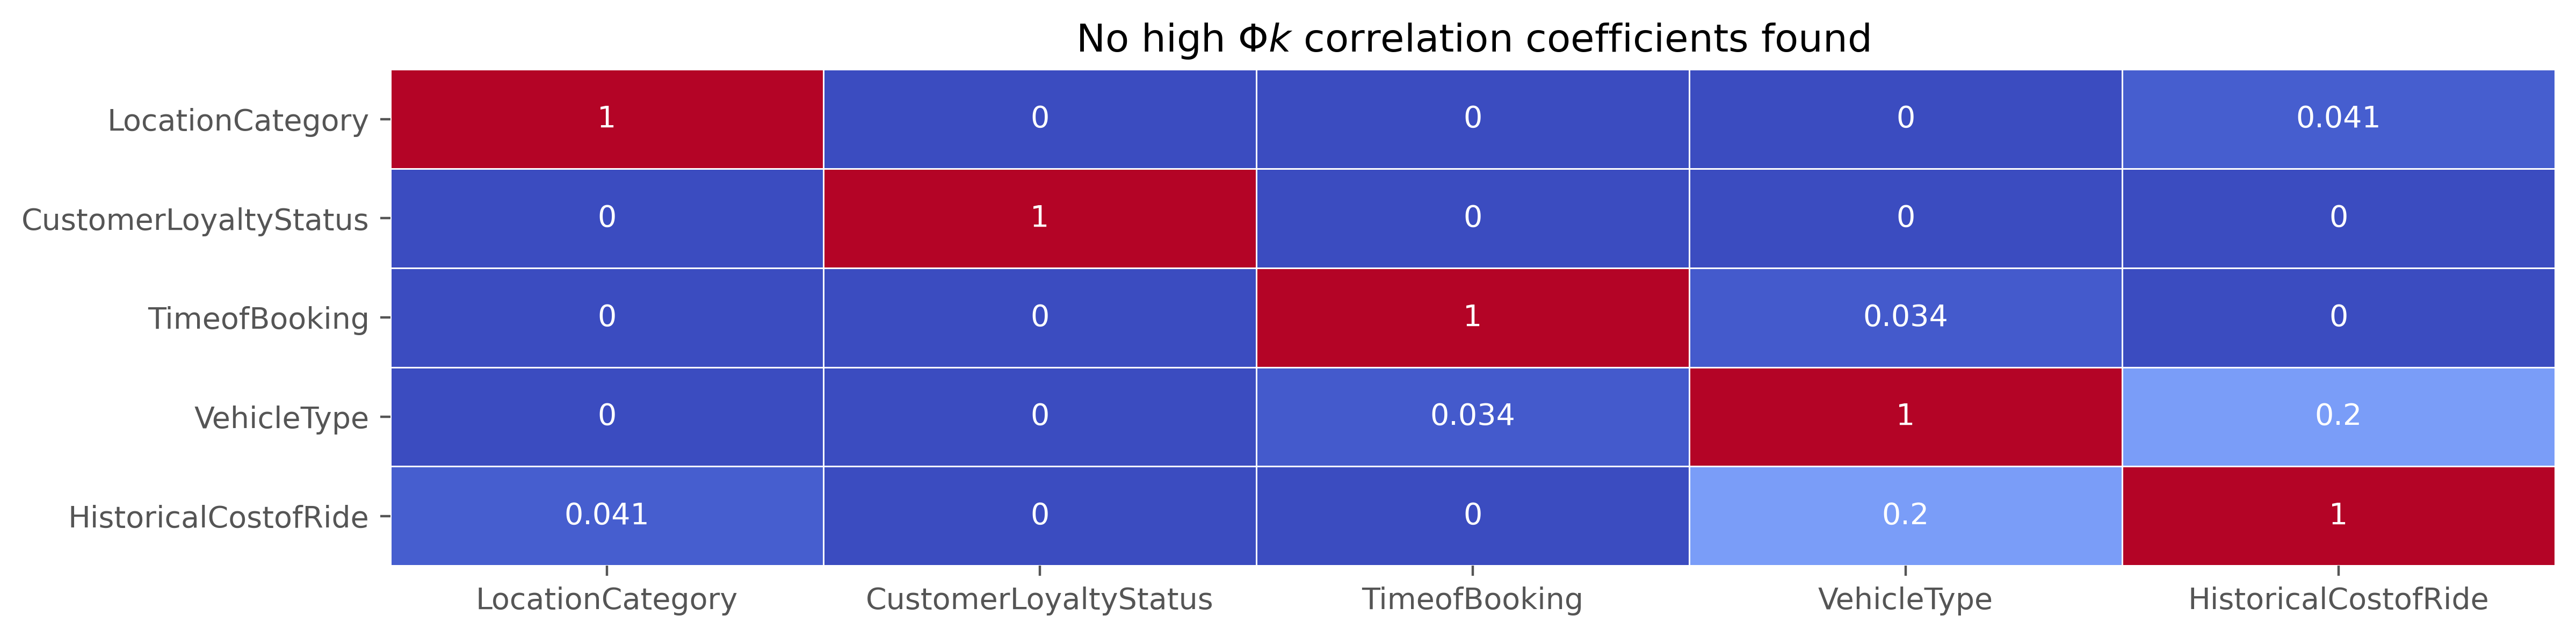

In [13]:
# build phi k correlation matrix
plt.figure(figsize=(13, 3), dpi=400)
cols = ['LocationCategory', 'CustomerLoyaltyStatus', 'TimeofBooking', 'VehicleType', 'HistoricalCostofRide']
phik_matrix = df[cols].phik_matrix(interval_cols=['HistoricalCostofRide']).round(4)
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', linewidths=0.5, cbar=False)
plt.title('No high $\Phi k$ correlation coefficients found', loc='center', fontsize=13)
plt.show()

**Note**: Based on $\Phi k$ correlation coefficients, no strong correlations can be detected, and hence, no potential multicolinearity is found in the categorical features, especially when relate them to the target variable, namely `HistoricalCostofRide`.

#### **2.5.2 Multicollinearity detection via VIF**
In its calculation, variance inflated factor (VIF) requires $R^2$ for the coefficient of determination (see below). When VIF is >5, the predictor is highly correlated with other variable(s).
$$\text{VIF} = \frac{1}{1-R^2}$$

In [14]:
# filter num vars
X = df.select_dtypes(include='number').drop(columns='HistoricalCostofRide')

# add intercept for VIF calculation
X = add_constant(X)

# compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data.round(4)

,Feature,VIF
0,const,112.9543
1,NumberofRiders,1.6487
2,NumberofDrivers,1.6535
3,NumberofPastRides,1.0070
4,AverageRatings,1.0068
5,ExpectedRideDuration,1.0018


**Note**
- As can be seen, there are no predictors with VIF greater than 5, indicating there is no multicollinarity issue in the data.
- While previously it was found that feature `NumberofRiders` is highly correlated with `NumberofDrivers` ($\rho$ = 0.62), their variance inflation factor (VIF) is 1.6, lower than 5. 
- Given the low VIF values, there is no strong reason for excluding either `NumberofDrivers` or `NumberofRiders` from the modeling phase. 
- For the `cons` (constant term) or the interpcept can be ignored since it is not a feature. It only represents the baseline value of the target variable when all features are zero.

### **2.6 Which variable does the company mainly use to set pricing?** 
My purpose here is to find out which variable is mainly used for determining the fares of ride sharing services. This can be done by exploring different categorical features to the target (`HistoricalCostofRide`). First, I will explore whether there are some differences between ride cost and time of booking. This provides insight whether, for example, the cost will increase in the evening. Second, another task is to investigate whether location of the service will influence the fares. For example, urban area may have higher fares than the rural area because the demand is usually higher. Third, as membership type can also be a contributing factor of the ride fares, a difference between these membership types can provide an understanding of, for example, gold membership will offer more benefits in terms of fares. Lastly, an exploration will also be done on ride fares and vehicle types. The more premium the vehiche, the higher the fares usually are. 

#### **2.6.1 Are there any difference in fares if customers rent the ride in a specific time?**

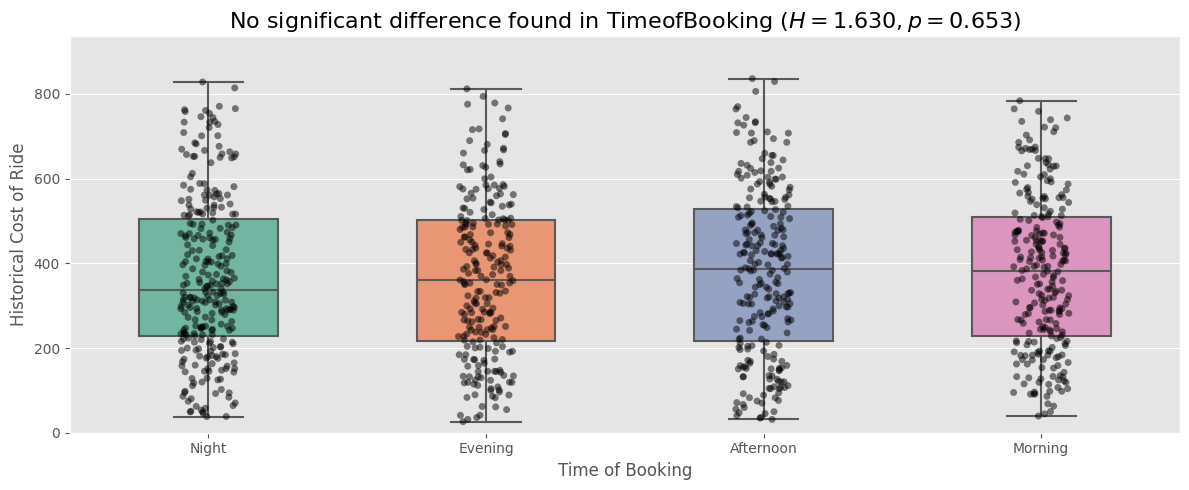

In [15]:
# Prepare data
groups = df['TimeofBooking'].unique()
group_data = [df[df['TimeofBooking'] == group]['HistoricalCostofRide'] for group in groups]

# visualize the difference
stat, p_value = kruskal(*group_data)
plt.figure(figsize=(12, 5))
sns.boxplot(x='TimeofBooking', y='HistoricalCostofRide', data=df, palette='Set2', width=0.5)
sns.stripplot(x='TimeofBooking', y='HistoricalCostofRide', data=df, color='k', alpha=0.5, jitter=True)
plt.title(f'No significant difference found in TimeofBooking ($H={stat:.3f}, p={p_value:.3f}$)', fontsize=16)
plt.ylim(0, df['HistoricalCostofRide'].max() + 100)
plt.xlabel('Time of Booking')
plt.ylabel('Historical Cost of Ride')
plt.tight_layout()
plt.show()

**Note**: Kruskal Wallis test reveals that whether booking the ride in the morning, afternoon, evening, or night does not significantly different (*H* = 1.630, *p* = 0.653). This finding implies that the time of booking may not be critical factor for the company to determine the fares.

#### **2.6.2 Are locations of rents in urban areas significantly more expensive?**

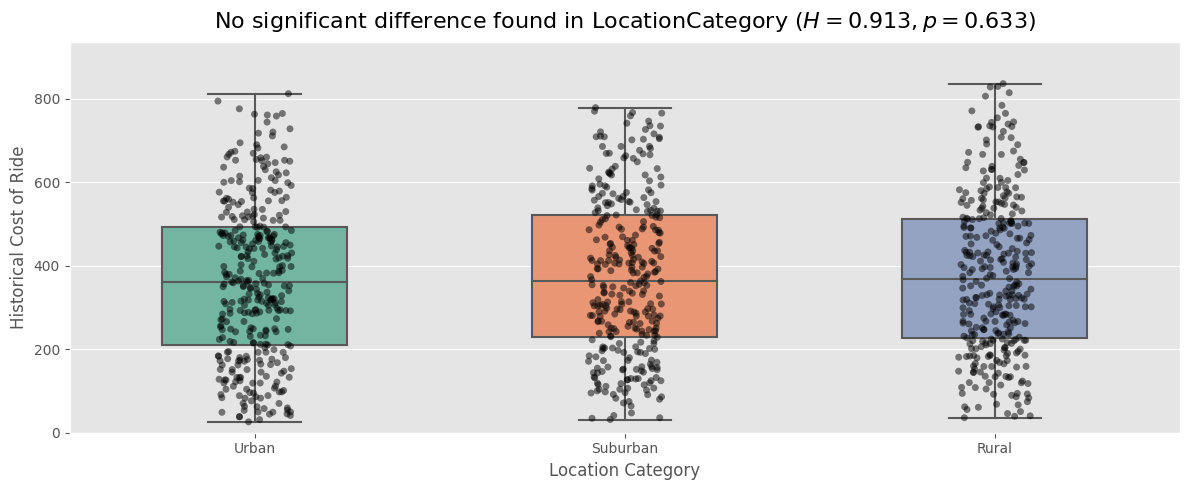

In [16]:
# Prepare data
groups = df['LocationCategory'].unique()
group_data = [df[df['LocationCategory'] == group]['HistoricalCostofRide'] for group in groups]

# visualize the difference
stat, p_value = kruskal(*group_data)
plt.figure(figsize=(12, 5))
sns.boxplot(x='LocationCategory', y='HistoricalCostofRide', data=df, palette='Set2', width=0.5)
sns.stripplot(x='LocationCategory', y='HistoricalCostofRide', data=df, color='k', alpha=0.5, jitter=True)
plt.title(f'No significant difference found in LocationCategory ($H={stat:.3f}, p={p_value:.3f}$)', pad=10, fontsize=16)
plt.ylim(0, df['HistoricalCostofRide'].max() + 100)
plt.xlabel('Location Category')
plt.ylabel('Historical Cost of Ride')

plt.tight_layout()
plt.show()

**Note**: Apparently, the locations in which customers make bookings are also not the main factor for the company to set ride fares. As can be seen, different locations show no significant difference in terms of costs (*H* = 0.913, *p* = 0.633).

#### **2.6.3 Do different membership types signify significantly different fares?**

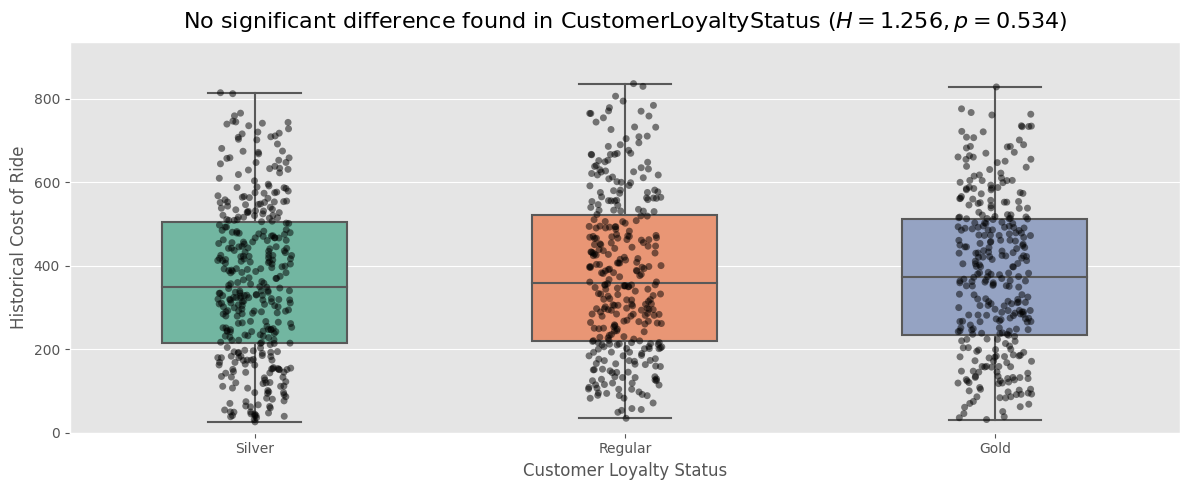

In [17]:
# Prepare data
groups = df['CustomerLoyaltyStatus'].unique()
group_data = [df[df['CustomerLoyaltyStatus'] == group]['HistoricalCostofRide'] for group in groups]

# visualize the difference
stat, p_value = kruskal(*group_data)
plt.figure(figsize=(12, 5))
sns.boxplot(x='CustomerLoyaltyStatus', y='HistoricalCostofRide', data=df, palette='Set2', width=0.5)
sns.stripplot(x='CustomerLoyaltyStatus', y='HistoricalCostofRide', data=df, color='k', alpha=0.5, jitter=True)
plt.title(f'No significant difference found in CustomerLoyaltyStatus ($H={stat:.3f}, p={p_value:.3f}$)', pad=10, fontsize=16)
plt.ylim(0, df['HistoricalCostofRide'].max() + 100)
plt.xlabel('Customer Loyalty Status')
plt.ylabel('Historical Cost of Ride')

plt.tight_layout()
plt.show()

**Note**: Similar to the previous three variables, customer membership statuses also do not show significant difference (*H* = 1.256, *p* = 0.534), indicating that whether customers hold silver, regular, or gold membership, the price will remain similar.

#### **2.6.4 If customers rent more premium vehicles, will the costs be significantly more expensive?**

In [18]:
# compute median cost per vehicle type
df.groupby('VehicleType')['HistoricalCostofRide'].median().round(2)

VehicleType
Economy    331.23
Premium    397.59
Name: HistoricalCostofRide, dtype: float64

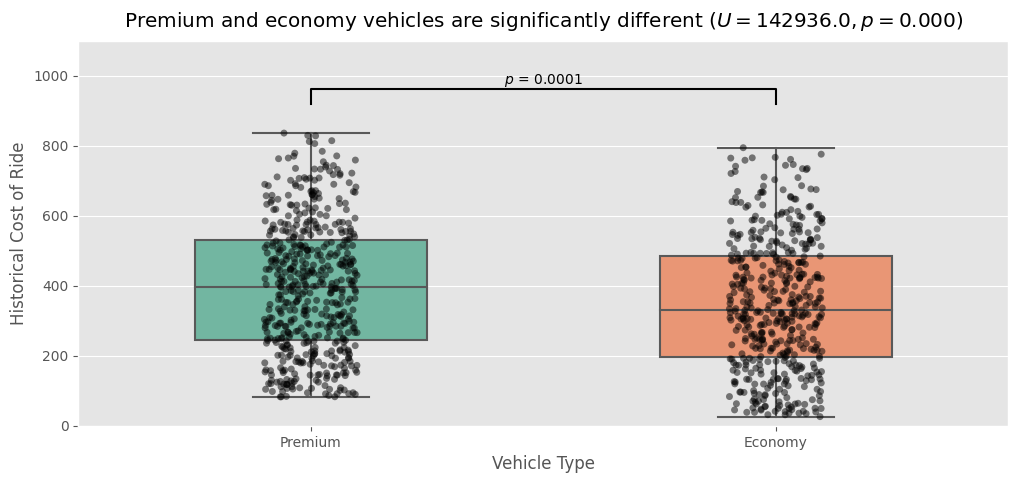

In [19]:
# Prepare data
vehicle_types = df['VehicleType'].unique()
data_group1 = df[df['VehicleType'] == vehicle_types[0]]['HistoricalCostofRide']
data_group2 = df[df['VehicleType'] == vehicle_types[1]]['HistoricalCostofRide']

# visualize the difference
stat, p_value = mannwhitneyu(data_group1, data_group2)
plt.figure(figsize=(12, 5))
sns.boxplot(x='VehicleType', y='HistoricalCostofRide', data=df, palette='Set2', width=0.5)
sns.stripplot(x='VehicleType', y='HistoricalCostofRide', data=df, color='k', alpha=0.5, jitter=True)

# calculate the vertical offset for annotations
max_y = max(df['HistoricalCostofRide'])
offset = max_y * 0.1  # 10% of the y-axis range as an offset

# determine positions for the bracket
x1, x2 = 0, 1
y = max_y + offset  # Vertical position of the bracket
h = offset * 0.5    # Height of the bracket
col = 'k'           # Color of the line and text

# add a bracket-style line
if p_value < 0.05:
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
    plt.text((x1 + x2) * 0.5, y + h, f'$p$ = {p_value:.4f}', ha='center', va='bottom', color=col)

plt.title(f'Premium and economy vehicles are significantly different ($U={stat}, p={p_value:.3f}$)', pad=10)
plt.xlabel('Vehicle Type')
plt.ylabel('Historical Cost of Ride')
plt.ylim(0, 1100)
plt.show()

**Note**: On the contrary to the three categorical variables, different vehicle types seem to be a crucial factor in setting the fares of rides. As can be seen the median premium vehicles is higher than the median of economy vehicle (USD 397.59 vs USD 331.23) with *U* = 142,936, *p* = 0.00. While this may not be a definitive answer, this result provides an indicative of vehicle type being a primary consideration for setting the prices.

#### **2.6.5 For longer time of rides, will the company charge customers significantly  higher?**

In [20]:
df2 = df.copy()

# calculate the median 
threshold = df['ExpectedRideDuration'].median()

# group duration
df2['DurationStatus'] = pd.cut(df['ExpectedRideDuration'], 
                            bins=[-float('inf'), threshold, float('inf')], 
                            labels=['ShortTime', 'LongTime'])

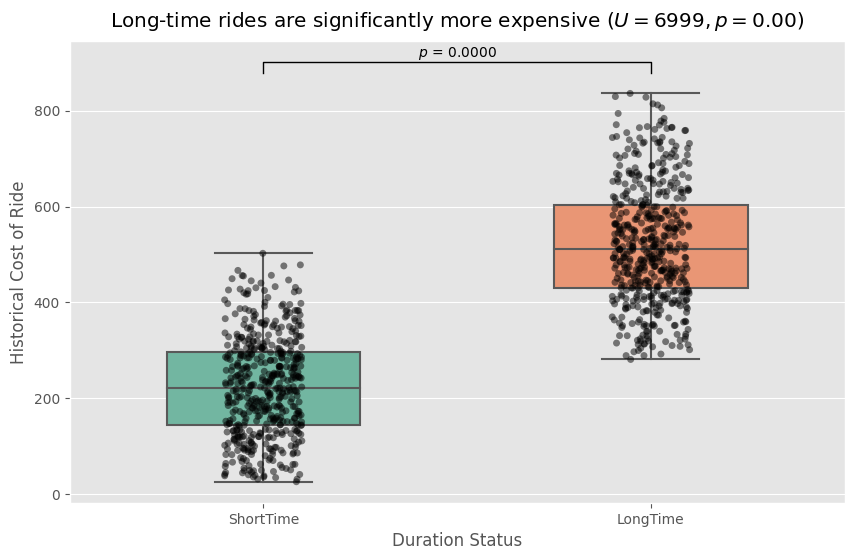

In [26]:
plt.figure(figsize=(10, 6))

# create the boxplot + jitter
sns.boxplot(x='DurationStatus', y='HistoricalCostofRide', data=df2, 
    palette='Set2', showfliers=False, width=0.5
)
sns.stripplot(
    x='DurationStatus', y='HistoricalCostofRide', data=df2, 
    color='k', alpha=0.5, jitter=True
)

# compute Mann-Whitney U test
short_time_costs = df2[df2['DurationStatus'] == 'ShortTime']['HistoricalCostofRide']
long_time_costs = df2[df2['DurationStatus'] == 'LongTime']['HistoricalCostofRide']
u_statistic, p_value = mannwhitneyu(short_time_costs, long_time_costs, alternative='two-sided')

# add a bracket if significant
if p_value < 0.05:
    x1, x2 = 0, 1  
    y = max(df2['HistoricalCostofRide']) * 1.05 
    h = (max(df2['HistoricalCostofRide']) - min(df2['HistoricalCostofRide'])) * 0.03 
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c='k')
    plt.text((x1 + x2) / 2, y + h, f'$p$ = {p_value:.4f}', ha='center', va='bottom', color='k')

plt.title(f'Long-time rides are significantly more expensive ($U={u_statistic:.0f}, p={p_value:.2f}$)', pad=10)
plt.xlabel('Duration Status')
plt.ylabel('Historical Cost of Ride')

plt.show()

**Note**: As indicated by the correlation test earlier, a significant, positive correlation is found between historical cost of rides and ride duration. And here, it is also found that users who book vehicle longer will need to pay higher than those who book the ride for a shorter time period (Mdn = USD 510.64 vs USD 221.49). In addition to vehicle types, duration of ride is also indicative of higher fares.

In [22]:
# compute median cost per duration status
df2.groupby('DurationStatus')['HistoricalCostofRide'].median().round(2)

DurationStatus
ShortTime    221.49
LongTime     510.64
Name: HistoricalCostofRide, dtype: float64

### **2.5 Summary**
This section aims to explore and clean the data before it passes to the machine learning models. It involves checking whether the parametric assumption of normality is met or not, whether there are outliers or not, whether there are rare labels, and whether there are highly correlated features. In brief, all data display non-normal distributions. There is one numerical variable contains outliers, namely `NumberofDrivers`. Moreover, rare labels were not found. For these reasons, a median-based scaling technique, namely robust scaler, will be applied on the training set to minimize the impacts of the outliers. Additionally, while `NumberofDrivers` and `NumberofRiders` are highly correlated, their high correlation does not seem a major issue when being seen using VIF. As a result, these features are retained and used for the modeling phase.

## **3 Predictive Modeling**
### **3.1 Introduction**
As the business goal is to build a regressor with minimum overestimation or underestimation of the ride cost, an ideal model is that with the smallest errors. In this section, I will conduct several experiments to investigate which model on what conditions can have the best performance. And to evaluate the performance of each regressor under different experiment setups, mean squared error (MAE), root mean squared error (RMSE), and R-squared ($R^2$) will be utilized. Just to recap their purposes which have been explained in Section 1.4,
- **Mean squared error (MAE)**: This metric evaluates prediction errors by treating small or big errors equally (no penalization for larger errors). MAE does this since it uses absolute value $|y_i-\hat{y}|$. Making the errors absolute means that direction of the errors (negative or positive) is not the concern. This metric only tells the magnitude of errors in the prediction. For example, MAE = 5 means that the prefiction if 5 units off from the actual value.
$$\text{MAE} = \frac{1}{n}\sum_{i=1}^n|y_i - \hat{y}_i|$$
- **Root mean squared error (RMSE)**: This metric also evaluates prediction errors but with penalization. By the penalization, larger errors will be penalized more. However, since RMSE involves squaring the errors, larger errors (outliers) can have significant impact on the RMSE value. In its interpretation, RMSE is similar to MAE but because it punishes larger error, RMSE value can be high if there are outliers.
$$\text{RMSE}=\sqrt{\frac{1}{n}\sum_{i=1}^1(y_i-\hat{y_1})^2}$$
- **R-squared** ($R^2$): This metric assesses a models' performance in explaining variance in the target variable. While this metric focuses more on statistical information rather than the business insight like MAE and RMSE, this metric remains useful for evaluating the overall fit of a model and how much variability in the target variable (`HistoricalCostofRide`) is explained by the predictors. For example, the R-squared of a model is 0.84 (scale 0 to 1), meaning 84% of the variability in `HistoricalCostofRide` is explained by the model.
$$
R^2=1-\frac{\sum_{i=1}^n(y_i-\hat{y}_i)^2}{\sum_{i=1}^n(y_i-\bar{y})^2}
$$
These three evaluation metrics of regressors are used but focusing on minimizing potential impact of pricing errors, RMSE will be the main priority for the evaluation. My reason is that this evaluation metric gives more penalization to larger errors, making RMSE suitable for minimizing the impacts. RMSE, therefore, addresses the risk of significant underestimation or overestimation in fare pricing prediction. 

Despite its effectiveness in penalizing larger errors (both underestimation and overestimation of prices), it is crucial to highlight the drawback of this metric: sensitivity to outliers. This trade-off between penalization and sensitivity to outliers is acceptable because outliers should be a rare case and financial impact of large errors is more important to the business.

### **3.2 ML Pipeline Preparation**

#### **3.2.1 Data Splitting**

In [23]:
# define features and target
X = df.drop(columns='HistoricalCostofRide')
y = df['HistoricalCostofRide']

RANDOM_STATE = 42

# split dataset
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE)

print(f'The X_train consists of {X_train.shape[0]} rows and {X_train.shape[1]} columns')
print(f'The y_train consists of {y_train.shape[0]} rows')
print(f'X_test consists of {X_test.shape[0]} rows and {X_test.shape[1]} columns')
print(f'The y_test consists of {y_test.shape[0]} rows')

The X_train consists of 900 rows and 9 columns
The y_train consists of 900 rows
X_test consists of 100 rows and 9 columns
The y_test consists of 100 rows


**Note**: Since the sample size for building a regressor is small (*N* = 1,000), choosing larger size of testing set is more preferred. For example, small training data can lead to various problems such as overfitting/underfitting and reduced model complexity. 
- Overfitting can occur when a regressor memorize the small dataset instead of learning the general patterns. This leads to poor performance in unseen data.
- A small dataset can also lead to underfitting. This case particularly happens when a regressor fails to learn underlying patterns, resulting in poor performance in both training and testing data.
- When using complex algorithms, e.g., Gradient Boosting Machine or Random Forest, a small training set may not be sufficient to support them because the complex algorithms cannot fully learn the complex patterns in the data.
Due to the limited data available, the data split is done 90%:10% in which 90% data is allocated for training, and 10% is used for testing. 

#### **3.2.2 Preprocessor Creation**

In [24]:
# identify numeric and categorical features
numeric_features = X.select_dtypes(include='number').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print('Numerical features:', numeric_features)
print('Categorical features:', categorical_features)

Numerical features: ['NumberofRiders', 'NumberofDrivers', 'NumberofPastRides', 'AverageRatings', 'ExpectedRideDuration']
Categorical features: ['LocationCategory', 'CustomerLoyaltyStatus', 'TimeofBooking', 'VehicleType']


**Note**: As previously mentioned Section 2.5, there are no predictors introducing multicolinearity to a model. An exclusion for a specific predictor is not needed. Here, I only distinguish features based on their data types (i.e., categorical and numerical) because they will require different treatments. For instance, while numerical features require rescaling to make all value ranges equal across features, values in categorical features will be transformed into numerical (encoding) so that they can be processed in the modeling process.

In [25]:
# create numerical transformer 
numerical_transformer = Pipeline(steps=[
  ('scaling', RobustScaler())
])

# create categorical transformer
categorical_transformer = Pipeline(steps=[
    ('cat', OneHotEncoder(handle_unknown='ignore'))
])

# assemble both transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaling', numerical_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

# display preprocessing pipeline
display(Pipeline(steps=[
    ('preprocessor', preprocessor)
]))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_scaling',
                                                  Pipeline(steps=[('scaling',
                                                                   RobustScaler())]),
                                                  ['NumberofRiders',
                                                   'NumberofDrivers',
                                                   'NumberofPastRides',
                                                   'AverageRatings',
                                                   'ExpectedRideDuration']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['LocationCategory',
                                                   'CustomerLoyaltyStatus',
                                                   'TimeofBooking',
                                                   'VehicleType'])]))])

**Note**: The pipeline above displays how different types of data are processed and will be fed to a machine learning algorithm. RobustScaler handles rescaling for numerical features such as `NumberofRiders`, `NumberofDrivers`, `NumberofPastRides`, `AverageRatings`, and `ExpectedRideDuration`. `OneHotEncoder`, on the other hand, encodes categories in categorical variables (`LocationCategory`, `CustomerLoyaltyStatus`, `TimeofBooking`, and `VehicleType`) into numerical values. Basically, `OneHotEncoder` converts every unique category into a binary number (1 and 0). While this encoding technique can introduce sparsity problem, this issue should not be a case in this project since no categorical variables have high cardinality.

#### **3.2.3 Preprocessed Data Check**

In [26]:
# fit and transform the data
X_preprocessed = preprocessor.fit_transform(X_train)
preprocessed_df = pd.DataFrame(X_preprocessed, columns=preprocessor.get_feature_names_out())

# check n of features
print(f'Training data after preprocessing consists of {preprocessed_df.shape[1]} features')

# display output
display(preprocessed_df.head().transpose())

Training data after preprocessing consists of 17 features


,0,1,2,3,4
num_scaling__NumberofRiders,-0.190476,-0.095238,0.738095,0.738095,0.238095
num_scaling__NumberofDrivers,-0.185185,0.592593,1.000000,0.555556,1.444444
num_scaling__NumberofPastRides,0.527919,-0.426396,-0.873096,-0.913706,0.548223
num_scaling__AverageRatings,-0.320000,-0.400000,-0.053333,0.866667,-0.560000
num_scaling__ExpectedRideDuration,-0.915663,-0.457831,-0.156627,0.012048,0.542169
categorical__LocationCategory_Rural,1.000000,0.000000,0.000000,1.000000,0.000000
categorical__LocationCategory_Suburban,0.000000,0.000000,0.000000,0.000000,1.000000
categorical__LocationCategory_Urban,0.000000,1.000000,1.000000,0.000000,0.000000
categorical__CustomerLoyaltyStatus_Gold,0.000000,0.000000,0.000000,0.000000,0.000000
categorical__CustomerLoyaltyStatus_Regular,0.000000,1.000000,0.000000,0.000000,1.000000


**Note**
- To see whether the preprocessor built previously work as expected, I need to fit and transform the training data using the preprocessor.
- The preprocessor, particularly onehot encoder and robust scaler, has done the job by transforming the categorical features into numerical ones, and rescale all numerical features into similar ranges.
- The effects of the preprocessing pipeline can also be seen from the names of the features. All categorical features will have prefix `categorical__` in front of the original name, and the numerical ones have `num_caling__` prefix. The prefixes were added automatically by the preprocessor as defined previously in the pipeline.

#### **3.2.3 ML Pipeline Creation**

In [27]:
# specify models for comparison
regressors = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge()),
    ('Lasso Regression', Lasso()),
    ('Decision Tree Regressor', DecisionTreeRegressor(random_state=RANDOM_STATE)),
    ('Random Forest Regressor', RandomForestRegressor(random_state=RANDOM_STATE)),
    ('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=RANDOM_STATE)),
    ('AdaBoost Regressor', AdaBoostRegressor(random_state=42)),
    ('XGBoost Regressor', XGBRegressor(eval_metric='rmse')),
    ('LightGBM Regressor', LGBMRegressor(random_state=RANDOM_STATE, verbose=-100)),
    ('CatBoost Regressor', CatBoostRegressor(random_state=RANDOM_STATE, verbose=0)),
    ('KNN Regressor', KNeighborsRegressor()),
    ('Support Vector Regressor', SVR(kernel='rbf'))
]

# define scorer
scoring = {
    'R2': make_scorer(r2_score),
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False))
}

# assemble algorithm and preprocessing in a pipeline
pipelines = [(name, Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])) for name, model in regressors]

**Note**: For building a baseline model and also for a comparison purpose, I include three groups of models, namely linear-based, tree-based, and distance-based models. The inclusion of various types of models here is expected to capture patterns in the data better.
- Linear-based models: Linear Regression, Ridge Regression, and Lasso Regression
- Tree-based models: Decision Tree, Random Forest, AdaBoost, XGBoost, LightGBM, and CatBoost
- Distance-based models: K-Nearest Neighbor, Support Vector Machine (Radial Basis Function kernel)

### **3.1 Experiment 1: Baseline Models**
This section is concerned with building models for benchmarks. It will involves comparing three groups of models (linear-based, tree-based, and distance-based models), selecting top-3 models based on the pre-defined metrics, tuning these top performing models, and comparing between untuned and tuned models to see how well the benchmark models can be.
#### **3.1.1 Baseline Model Comparison**

In [28]:
# use K-Fold cv
kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# eval each model via model comparison
results = []
for name, pipeline in pipelines:
    scores = {}
    start_time = time.time()
    for metric_name, scorer in scoring.items():
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=scorer, n_jobs=-1)
        scores[f"{metric_name}_Mean"] = np.mean(cv_scores)
        scores[f"{metric_name}_SD"] = np.std(cv_scores)
    end_time = time.time()
    training_time = end_time - start_time
    scores['TT'] = training_time
    results.append((name, scores))

# put results in df for easier comparison
results_df = pd.DataFrame(results, columns=['Model', 'Scores'])
scores_df = results_df['Scores'].apply(pd.Series)
results_df = pd.concat([results_df[['Model']], scores_df], axis=1)
results_df = results_df.set_index('Model')

In [29]:
# display output
results_df.round(3).sort_values(by='RMSE_Mean', ascending=True)

,R2_Mean,R2_SD,MAE_Mean,MAE_SD,RMSE_Mean,RMSE_SD,TT
Model,,,,,,,
Lasso Regression,0.875,0.027,51.479,5.836,65.611,6.815,0.088
Ridge Regression,0.873,0.029,52.048,6.137,66.037,7.113,0.096
Linear Regression,0.872,0.030,52.116,6.271,66.222,7.329,0.262
Gradient Boosting Regressor,0.867,0.029,52.924,5.487,67.556,6.401,0.771
CatBoost Regressor,0.864,0.033,53.257,6.178,68.342,7.647,8.747
AdaBoost Regressor,0.862,0.027,55.577,5.658,68.924,6.750,0.427
Random Forest Regressor,0.860,0.032,53.289,5.922,69.389,7.481,2.074
LightGBM Regressor,0.856,0.034,54.092,5.781,69.969,6.691,6.864
XGBoost Regressor,0.843,0.044,55.885,6.974,73.131,8.392,0.474


**Note**
- Let me begin the explanation by pointing out the higher performance of linear-based models over tree-based and distance-based models. As can be seen the top-three models are Lasso, Ridge, and Linear Regression (linear-based). On the rank 4th to 6th, tree-based models are listed here, and followed by K-NN and SVM as the distance-based models. One important discussion here might be, "Why do linear-based models outperform other model types?" One reasonable guess is the approximately linear nature of the data. The linearity can be investigated using a residual plot which will be done later after finding the best model across all experiments.
- Besides, Lasso Regression appears to be the highest performing model in the comparison table. The mean of RMSE is 65.511 $\pm$ 6.815, indicating it has the smallest average prediction error, penalizing larger errors mode heavily than other models.
- While RMSE is the primary evaluation metric here, Lasso Regression also excels in the MAE and $R^2$.
- The linear-based model shows the smallest mean MAE (51.479), suggesting its better performance in the magnitude of errors.
- Lastly, this model also has a high $R^2$ value of 0.875. This result suggests that this model explains a significant portion of the variance in `HistoricalCostofRide`.
- These results serve as benchmarks for the machine learning models. While Lasso Regression shows excellent performance scores here, this model might not be the highest performing model on the unseen data (test data).

#### **3.1.2 Regressor Building: Top-3 Models**

In [30]:
# build pipelines
exp1_reg_linear = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
exp1_reg_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])
exp1_reg_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(max_iter=20000))
])

# fit each model on seen data
exp1_reg_linear.fit(X_train, y_train)
exp1_reg_ridge.fit(X_train, y_train)
exp1_reg_lasso.fit(X_train, y_train)

# make predictions on unseen data
y_pred_linear = exp1_reg_linear.predict(X_test)
y_pred_ridge = exp1_reg_ridge.predict(X_test)
y_pred_lasso = exp1_reg_lasso.predict(X_test)

In [31]:
# eval metrics for linear regression
exp1_rmse_linear = mean_squared_error(y_test, y_pred_linear, squared=False)
exp1_mae_linear = mean_absolute_error(y_test, y_pred_linear)
exp1_r2_linear = r2_score(y_test, y_pred_linear)

# eval metrics for ridge regression
exp1_rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
exp1_mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
exp1_r2_ridge = r2_score(y_test, y_pred_ridge)

# eval metrics for lasso regression
exp1_rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
exp1_mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
exp1_r2_lasso = r2_score(y_test, y_pred_lasso)

exp1_untuned_testing = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression'],
    'R2': [exp1_r2_linear, exp1_r2_ridge, exp1_r2_lasso],
    'RMSE': [exp1_rmse_linear, exp1_rmse_ridge, exp1_rmse_lasso],
    'MAE': [exp1_mae_linear, exp1_mae_ridge, exp1_mae_lasso]
}).round(4)

print('Performance of the top-3 untuned models on testing set:')
display(exp1_untuned_testing.sort_values(by='RMSE'))

Performance of the top-3 untuned models on testing set:


,Model,R2,RMSE,MAE
2,Lasso Regression,0.8487,68.4409,52.6218
1,Ridge Regression,0.8465,68.9318,53.8350
0,Linear Regression,0.8464,68.9538,53.4888


**Note**
- In testing data, Lasso Regression remains the most excellent model in predicting the fares of ride services despite score decrease in $R^2$ in 0.025 (0.875-0.8500 in training set and testing set, respectively) and slight increase in errors (RMSE and MAE). However, the differences are normal because these scores are the Lasso Regression's performance in unseen data.
- To note: The higher the $R^2$ score, the better the performance is, and for RMSE and MAE, the lower the error score, the better the performance is.
- To further investigate how the models, including Lasso Regression, will perform after hyperparameter tuning against unseen data to see the models' learning, I will compare the untuned and tuned versions of each model.

#### **3.1.3 Hyperparameter Tuning: Top-3 Models**

In [32]:
# define parameter grids for each model
param_grid_linear = {} # no hyperparam for linear regression

param_grid_ridge = {
    'regressor__alpha': [0.1, 1, 10, 100],
    'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr'],
    'regressor__fit_intercept': [True, False],
    'regressor__tol': [1e-4, 1e-3, 1e-2],
    'regressor__max_iter': [None, 1000, 5000, 10000]
}

param_grid_lasso = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'regressor__tol': [0.0001, 0.001, 0.01],
    'regressor__max_iter': [1000, 5000, 10000],
    'regressor__selection': ['cyclic', 'random']
}

# create GridSearchCV instance: linear regression
exp1_grid_search_linear = GridSearchCV(
    estimator=exp1_reg_linear,
    param_grid=param_grid_linear,
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2'],  
    refit = 'neg_root_mean_squared_error',
    cv=10,
    n_jobs=-1
)

# create GridSearchCV instance: ridge regression
exp1_grid_search_ridge = GridSearchCV(
    estimator=exp1_reg_ridge,
    param_grid=param_grid_ridge,
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
    refit = 'neg_root_mean_squared_error',
    cv=10,
    n_jobs=-1
)

# create GridSearchCV instance: lasso regression
exp1_grid_search_lasso = GridSearchCV(
    estimator=exp1_reg_lasso,
    param_grid=param_grid_lasso,
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
    refit = 'neg_root_mean_squared_error',
    cv=10,
    n_jobs=-1
)

In [33]:
# fit GridSearchCV: Linear Regression
start_time = time.time()
exp1_grid_search_linear.fit(X_train, y_train)
end_time = time.time()
time_required = end_time - start_time
print(f"Time taken for Linear Regression: {time_required:.2f} seconds")

Time taken for Linear Regression: 0.08 seconds


In [34]:
# fit GridSearchCV: Ridge Regression
start_time = time.time()
exp1_grid_search_ridge.fit(X_train, y_train)
end_time = time.time()
time_required = end_time - start_time
print(f"Time taken for Ridge Regression: {time_required:.2f} seconds")

Time taken for Ridge Regression: 7.65 seconds


In [35]:
# fit GridSearchCV: Lasso Regression
start_time = time.time()
exp1_grid_search_lasso.fit(X_train, y_train)
end_time = time.time()
time_required = end_time - start_time
print(f"Time taken for Lasso Regression: {time_required:.2f} seconds")

/Users/adeliajanuarto/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.280e+05, tolerance: 2.831e+03
  model = cd_fast.enet_coordinate_descent(


Time taken for Lasso Regression: 2.84 seconds


In [36]:
exp1_results = {
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression'],
    'Best_Param': [
        exp1_grid_search_linear.best_params_,
        exp1_grid_search_ridge.best_params_,
        exp1_grid_search_lasso.best_params_
    ],
    'R2_Mean': [
        exp1_grid_search_linear.cv_results_['mean_test_r2'][exp1_grid_search_linear.best_index_],
        exp1_grid_search_ridge.cv_results_['mean_test_r2'][exp1_grid_search_ridge.best_index_],
        exp1_grid_search_lasso.cv_results_['mean_test_r2'][exp1_grid_search_lasso.best_index_]
    ],
    'R2_SD': [
        exp1_grid_search_linear.cv_results_['std_test_r2'][exp1_grid_search_linear.best_index_],
        exp1_grid_search_ridge.cv_results_['std_test_r2'][exp1_grid_search_ridge.best_index_],
        exp1_grid_search_lasso.cv_results_['std_test_r2'][exp1_grid_search_lasso.best_index_]
    ],
    # adding negative to correct the MAE value
    'MAE_Mean': [
        -exp1_grid_search_linear.cv_results_['mean_test_neg_root_mean_squared_error'][exp1_grid_search_linear.best_index_],
        -exp1_grid_search_ridge.cv_results_['mean_test_neg_root_mean_squared_error'][exp1_grid_search_ridge.best_index_],
        -exp1_grid_search_lasso.cv_results_['mean_test_neg_root_mean_squared_error'][exp1_grid_search_lasso.best_index_]
    ],
    'MAE_SD': [
        exp1_grid_search_linear.cv_results_['std_test_neg_root_mean_squared_error'][exp1_grid_search_linear.best_index_],
        exp1_grid_search_ridge.cv_results_['std_test_neg_root_mean_squared_error'][exp1_grid_search_ridge.best_index_],
        exp1_grid_search_lasso.cv_results_['std_test_neg_root_mean_squared_error'][exp1_grid_search_lasso.best_index_]
    ],
    # adding negative to correct the RMSE value
    'RMSE_Mean': [
        -exp1_grid_search_linear.cv_results_['mean_test_neg_root_mean_squared_error'][exp1_grid_search_linear.best_index_],
        -exp1_grid_search_ridge.cv_results_['mean_test_neg_root_mean_squared_error'][exp1_grid_search_ridge.best_index_],
        -exp1_grid_search_lasso.cv_results_['mean_test_neg_root_mean_squared_error'][exp1_grid_search_lasso.best_index_]
    ],
    'RMSE_SD': [
        exp1_grid_search_linear.cv_results_['std_test_neg_root_mean_squared_error'][exp1_grid_search_linear.best_index_],
        exp1_grid_search_ridge.cv_results_['std_test_neg_root_mean_squared_error'][exp1_grid_search_ridge.best_index_],
        exp1_grid_search_lasso.cv_results_['std_test_neg_root_mean_squared_error'][exp1_grid_search_lasso.best_index_]
    ]
}

# put mean and sd of scores into df
exp1_tuned_training = pd.DataFrame(exp1_results).round(4).sort_values(by='RMSE_Mean')

In [37]:
# display df
pd.options.display.max_colwidth = None
print('Model performance on training data:')
display(exp1_tuned_training)

Model performance on training data:


,Model,Best_Param,R2_Mean,R2_SD,MAE_Mean,MAE_SD,RMSE_Mean,RMSE_SD
2,Lasso Regression,"{'regressor__alpha': 1, 'regressor__max_iter': 5000, 'regressor__selection': 'random', 'regressor__tol': 0.01}",0.8744,0.0219,65.5026,5.6168,65.5026,5.6168
1,Ridge Regression,"{'regressor__alpha': 1, 'regressor__fit_intercept': True, 'regressor__max_iter': None, 'regressor__solver': 'lsqr', 'regressor__tol': 0.01}",0.8733,0.0222,65.7943,5.5749,65.7943,5.5749
0,Linear Regression,{},0.8726,0.0223,65.9752,5.5165,65.9752,5.5165


**Note**
- Here, the best model should have the least RMSE and MAE mean since the larger RMSE and MAE, the higher number of errors the model has. Other than these two, the best model needs to have the highest R-squared. 
- And based on the output, Lasso Regression is the best model. Both RMSE and MAE are constantly the lowest among the three candidates. The R-squared is also the highest.

In [38]:
# eval Lasso Regression on test set
tuned_lasso = exp1_grid_search_lasso.best_estimator_
y_pred_lasso = tuned_lasso.predict(X_test)
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

# eval Ridge Regression on test set
tuned_ridge = exp1_grid_search_ridge.best_estimator_
y_pred_ridge = tuned_ridge.predict(X_test)
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# eval Linear Regression on test set
tuned_linear = exp1_grid_search_linear.best_estimator_
y_pred_linear = tuned_linear.predict(X_test)
rmse_linear = mean_squared_error(y_test, y_pred_linear, squared=False)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# put results in a df
results_tuned_testing = {
    'Model': ['Lasso Regression', 'Ridge Regression', 'Linear Regression'],
    'R2': [r2_lasso, r2_ridge, r2_linear],
    'RMSE': [rmse_lasso, rmse_ridge, rmse_linear],
    'MAE': [mae_lasso, mae_ridge, mae_linear],

}
print('Evaluation metrics on test set:')
exp1_tuned_testing = pd.DataFrame(results_tuned_testing).round(4)
display(exp1_tuned_testing)

Evaluation metrics on test set:


,Model,R2,RMSE,MAE
0,Lasso Regression,0.8486,68.4604,52.6251
1,Ridge Regression,0.8470,68.8330,53.7728
2,Linear Regression,0.8464,68.9538,53.4888


**Note**: The performance of three candidates slightly changes when being tested on the unseen data but this condition is normal since the models have not learned the patterns in the data. The slight changes also indicate good generalizability of these models since the difference between performance in training and testing data is small.

#### **3.1.4 Untuned and Tuned Model Comparison**

In [39]:
# display both untuned and tuned version
display(exp1_untuned_testing.sort_values(by=['RMSE', 'MAE', 'R2']), 
        exp1_tuned_testing.sort_values(by=['RMSE', 'MAE', 'R2']))

,Model,R2,RMSE,MAE
2,Lasso Regression,0.8487,68.4409,52.6218
1,Ridge Regression,0.8465,68.9318,53.8350
0,Linear Regression,0.8464,68.9538,53.4888


,Model,R2,RMSE,MAE
0,Lasso Regression,0.8486,68.4604,52.6251
1,Ridge Regression,0.8470,68.8330,53.7728
2,Linear Regression,0.8464,68.9538,53.4888


**Note**
- All performance metrics indicate good changes in all candidate models, except for Lasso Regression.
- **R2**: The R-squared scores after tuning increase, except for Lasso Regression. The worse performance of Lasso Regression after hyperparameter tuning, however, is not substantial. The R-squared value only decreases by 0.01.
- **RMSE** and **MAE**: RMSE scores appear to decrease after tuning the models, except for Lasso Regression.

### **3.2 Experiment 2: Feature Selection**
This section evaluates how applying feature selection affects the models performance. In general, feature selection involves selecting the most relevant features from a dataset. Selecting the most relevant features reduces the potential overfitting because smaller feature set results in simpler model.

#### **3.2.1 Model Building**

In [40]:
# add feature selection to the pipeline
reg_linear = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression)), 
    ('regressor', LinearRegression())
])

reg_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression)),  
    ('regressor', Ridge())
])

reg_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression)),  
    ('regressor', Lasso())
])

**Note**: Rather than selecting directly the number of features (`k`) in `SelectKBest`, I keep it to the hyperparameter tuning so the `GridSearchCV` will automatically choose which `k` is the most optimal. To note, when `k` is not specified, by default, SelectKBest will use `k='all'` (see the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)).

In [41]:
# fit each model on seen data
reg_linear.fit(X_train, y_train)
reg_ridge.fit(X_train, y_train)
reg_lasso.fit(X_train, y_train)

# make predictions on unseen data
y_pred_linear = reg_linear.predict(X_test)
y_pred_ridge = reg_ridge.predict(X_test)
y_pred_lasso = reg_lasso.predict(X_test)

In [42]:
# eval metrics for linear regression
rmse_linear = mean_squared_error(y_test, y_pred_linear, squared=False)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# eval metrics for ridge regression
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Evaluate metrics for Lasso Regression
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

exp2_untuned_testing = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression'],
    'R2': [r2_linear, r2_ridge, r2_lasso],
    'RMSE': [rmse_linear, rmse_ridge, rmse_lasso],
    'MAE': [mae_linear, mae_ridge, mae_lasso]
}).round(4)

print('Performance of the top-3 untuned models on testing set:')
display(exp2_untuned_testing.sort_values(by='RMSE', ascending=True))

Performance of the top-3 untuned models on testing set:


,Model,R2,RMSE,MAE
2,Lasso Regression,0.8490,68.3641,52.5381
0,Linear Regression,0.8470,68.8344,53.5165
1,Ridge Regression,0.8469,68.8523,53.4724


**Note**: Similar to the previous experiments, Lasso Regression is the most ideal model among the three candidates. Lasso Regression has the smallest RMSE and MAE values but the highest $R^2$ when being tested on the testing data.

#### **3.2.2 Hyperparameter Tuning**

In [43]:
# define parameter grids for each model
param_grid_linear = {'feature_selection__k': [5, 6, 7, 8, 9, 'all']} 

param_grid_ridge = {
    'feature_selection__k': [5, 6, 7, 8, 9, 'all'], 
    'regressor__alpha': [0.1, 1, 10, 100],
    'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr'],
    'regressor__fit_intercept': [True, False],
    'regressor__tol': [1e-4, 1e-3, 1e-2],
    'regressor__max_iter': [None, 1000, 5000, 10000]
}

param_grid_lasso = {
    'feature_selection__k': [5, 6, 7, 8, 9, 'all'],
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'regressor__tol': [0.0001, 0.001, 0.01],
    'regressor__max_iter': [1000, 5000, 10000],
    'regressor__selection': ['cyclic', 'random']
}

In [44]:
# create GridSearchCV instance: linear regression
exp2_grid_search_linear = GridSearchCV(
    estimator=reg_linear,
    param_grid=param_grid_linear,
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2'],  
    refit = 'neg_root_mean_squared_error',
    cv=10,
    n_jobs=-1
)

# create GridSearchCV instance: ridge regression
exp2_grid_search_ridge = GridSearchCV(
    estimator=reg_ridge,
    param_grid=param_grid_ridge,
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
    refit = 'neg_root_mean_squared_error',
    cv=10,
    n_jobs=-1
)

# create GridSearchCV instance: lasso regression
exp2_grid_search_lasso = GridSearchCV(
    estimator=reg_lasso,
    param_grid=param_grid_lasso,
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
    refit = 'neg_root_mean_squared_error',
    cv=10,
    n_jobs=-1
)

In [45]:
# fit GridSearchCV: Linear Regression
start_time = time.time()
exp2_grid_search_linear.fit(X_train, y_train)
end_time = time.time()
time_required = end_time - start_time
print(f"Time taken for Linear Regression: {time_required:.2f} seconds")

Time taken for Linear Regression: 0.22 seconds


In [46]:
# fit GridSearchCV: Ridge Regression
start_time = time.time()
exp2_grid_search_ridge.fit(X_train, y_train)
end_time = time.time()
time_required = end_time - start_time
print(f"Time taken for Ridge Regression: {time_required:.2f} seconds")

Time taken for Ridge Regression: 50.49 seconds


In [47]:
# fit GridSearchCV: Ridge Regression
start_time = time.time()
exp2_grid_search_lasso.fit(X_train, y_train)
end_time = time.time()
time_required = end_time - start_time
print(f"Time taken for Ridge Regression: {time_required:.2f} seconds")

/Users/adeliajanuarto/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.153e+05, tolerance: 2.831e+03
  model = cd_fast.enet_coordinate_descent(


Time taken for Ridge Regression: 16.19 seconds


In [48]:
exp2_results = {
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression'],
    'Best_Param': [
        exp2_grid_search_linear.best_params_,
        exp2_grid_search_ridge.best_params_,
        exp2_grid_search_lasso.best_params_
    ],
    'R2_Mean': [
        exp2_grid_search_linear.cv_results_['mean_test_r2'][exp2_grid_search_linear.best_index_],
        exp2_grid_search_ridge.cv_results_['mean_test_r2'][exp2_grid_search_ridge.best_index_],
        exp2_grid_search_lasso.cv_results_['mean_test_r2'][exp2_grid_search_lasso.best_index_]
    ],
    'R2_SD': [
        exp2_grid_search_linear.cv_results_['std_test_r2'][exp2_grid_search_linear.best_index_],
        exp2_grid_search_ridge.cv_results_['std_test_r2'][exp2_grid_search_ridge.best_index_],
        exp2_grid_search_lasso.cv_results_['std_test_r2'][exp2_grid_search_lasso.best_index_]
    ],
    # adding negative to correct the MAE value
    'MAE_Mean': [
        -exp2_grid_search_linear.cv_results_['mean_test_neg_root_mean_squared_error'][exp2_grid_search_linear.best_index_],
        -exp2_grid_search_ridge.cv_results_['mean_test_neg_root_mean_squared_error'][exp2_grid_search_ridge.best_index_],
        -exp2_grid_search_lasso.cv_results_['mean_test_neg_root_mean_squared_error'][exp2_grid_search_lasso.best_index_]
    ],
    'MAE_SD': [
        exp2_grid_search_linear.cv_results_['std_test_neg_root_mean_squared_error'][exp2_grid_search_linear.best_index_],
        exp2_grid_search_ridge.cv_results_['std_test_neg_root_mean_squared_error'][exp2_grid_search_ridge.best_index_],
        exp2_grid_search_lasso.cv_results_['std_test_neg_root_mean_squared_error'][exp2_grid_search_lasso.best_index_]
    ],
    # adding negative to correct the RMSE value
    'RMSE_Mean': [
        -exp2_grid_search_linear.cv_results_['mean_test_neg_root_mean_squared_error'][exp2_grid_search_linear.best_index_],
        -exp2_grid_search_ridge.cv_results_['mean_test_neg_root_mean_squared_error'][exp2_grid_search_ridge.best_index_],
        -exp2_grid_search_lasso.cv_results_['mean_test_neg_root_mean_squared_error'][exp2_grid_search_lasso.best_index_]
    ],
    'RMSE_SD': [
        exp2_grid_search_linear.cv_results_['std_test_neg_root_mean_squared_error'][exp2_grid_search_linear.best_index_],
        exp2_grid_search_ridge.cv_results_['std_test_neg_root_mean_squared_error'][exp2_grid_search_ridge.best_index_],
        exp2_grid_search_lasso.cv_results_['std_test_neg_root_mean_squared_error'][exp2_grid_search_lasso.best_index_]
    ]
}

# put mean and sd of scores into df
exp2_tuned_training = pd.DataFrame(exp2_results).round(4).sort_values(by='RMSE_Mean')

In [49]:
pd.options.display.max_colwidth = None
exp2_tuned_training

,Model,Best_Param,R2_Mean,R2_SD,MAE_Mean,MAE_SD,RMSE_Mean,RMSE_SD
2,Lasso Regression,"{'feature_selection__k': 'all', 'regressor__alpha': 1, 'regressor__max_iter': 5000, 'regressor__selection': 'random', 'regressor__tol': 0.01}",0.8745,0.0221,65.4841,5.6765,65.4841,5.6765
1,Ridge Regression,"{'feature_selection__k': 'all', 'regressor__alpha': 1, 'regressor__fit_intercept': True, 'regressor__max_iter': None, 'regressor__solver': 'lsqr', 'regressor__tol': 0.01}",0.8733,0.0222,65.7943,5.5749,65.7943,5.5749
0,Linear Regression,{'feature_selection__k': 'all'},0.8729,0.0228,65.8625,5.4776,65.8625,5.4776


In [50]:
# retrtieve best model
exp2_tuned_lasso = exp2_grid_search_lasso.best_estimator_
exp2_tuned_ridge = exp2_grid_search_ridge.best_estimator_
exp2_tuned_linear = exp2_grid_search_linear.best_estimator_

# make prediction on X_test
exp2_y_pred_lasso = exp2_tuned_lasso.predict(X_test)
exp2_y_pred_ridge = exp2_tuned_ridge.predict(X_test)
exp2_y_pred_linear = exp2_tuned_linear.predict(X_test)

# evaluate performance
rmse_lasso = mean_squared_error(y_test, exp2_y_pred_lasso, squared=False)
mae_lasso = mean_absolute_error(y_test, exp2_y_pred_lasso)
r2_lasso = r2_score(y_test, exp2_y_pred_lasso)

rmse_ridge = mean_squared_error(y_test, exp2_y_pred_ridge, squared=False)
mae_ridge = mean_absolute_error(y_test, exp2_y_pred_ridge)
r2_ridge = r2_score(y_test, exp2_y_pred_ridge)

rmse_linear = mean_squared_error(y_test, exp2_y_pred_linear, squared=False)
mae_linear = mean_absolute_error(y_test, exp2_y_pred_linear)
r2_linear = r2_score(y_test, exp2_y_pred_linear)

# Create a dictionary to store the results
results = {
    'Model': ['Lasso Regression', 'Ridge Regression', 'Linear Regression'],
    'R2': [r2_lasso, r2_ridge, r2_linear],
    'RMSE': [rmse_lasso, rmse_ridge, rmse_linear],
    'MAE': [mae_lasso, mae_ridge, mae_linear]
}

# Convert the dictionary into a DataFrame and display it
exp2_tuned_testing = pd.DataFrame(results).round(4)
display(exp2_tuned_testing)

,Model,R2,RMSE,MAE
0,Lasso Regression,0.8487,68.4409,52.6219
1,Ridge Regression,0.8470,68.8330,53.7728
2,Linear Regression,0.8461,69.0271,53.7088


#### **3.2.3 Untuned and Tuned Model Comparison**

In [51]:
display(exp2_untuned_testing.sort_values(by=['RMSE', 'MAE', 'R2']), 
        exp2_tuned_testing.sort_values(by=['RMSE', 'MAE', 'R2']))

,Model,R2,RMSE,MAE
2,Lasso Regression,0.8490,68.3641,52.5381
0,Linear Regression,0.8470,68.8344,53.5165
1,Ridge Regression,0.8469,68.8523,53.4724


,Model,R2,RMSE,MAE
0,Lasso Regression,0.8487,68.4409,52.6219
1,Ridge Regression,0.8470,68.8330,53.7728
2,Linear Regression,0.8461,69.0271,53.7088


**Note**
- The comparison between untuned and tuned models in the test set suggests that Lasso Regression is still the top performing model. 
- Unexpectedly, the untuned versions slightly perform better than the tuned models. This condition means that the hyperparameter tuning, instead of increasing the models' performance, it decreases the performance. 

### **3.3 Experiment 3: Polynomial Expansion**
Polynomial expansion is a part of feature creations with a focus on generating new features based on the existing ones. This feature creation technique utilizes polynomial combinations of features. Here, I will use degree 3 with interaction pattern of $[1, 1, b, a^2, ab, b^2, a^3, a^2b, ab^2, b^3]$. By using this technique, ML model is introduced to non-linearity, and this is useful when the relationship between predictors and the target is not linear.

#### **3.3.1 Model Building**

In [52]:
# add polynomial features to the pipeline
reg_linear = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
    ('regressor', LinearRegression())
])

reg_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
    ('regressor', Ridge())
])

reg_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
    ('regressor', Lasso(max_iter=20000))
])

**Note**
- Cubic term `(degree=3)` is assembled in the pipeline. In general, the higher degre, the higher the model performance is. This is particularly true if the relationship between the features and target is not linear.
- Moreover, the higher the degree, the number of features (or dimension of the training set) will also increase.

In [53]:
# fit each model on seen data
reg_linear.fit(X_train, y_train)
reg_ridge.fit(X_train, y_train)
reg_lasso.fit(X_train, y_train)

# make predictions on unseen data
y_pred_linear = reg_linear.predict(X_test)
y_pred_ridge = reg_ridge.predict(X_test)
y_pred_lasso = reg_lasso.predict(X_test)

In [54]:
# eval metrics for linear regression
rmse_linear = mean_squared_error(y_test, y_pred_linear, squared=False)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# eval metrics for ridge regression
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Evaluate metrics for Lasso Regression
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

exp3_untuned_testing = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression'],
    'R2': [r2_linear, r2_ridge, r2_lasso],
    'RMSE': [rmse_linear, rmse_ridge, rmse_lasso],
    'MAE': [mae_linear, mae_ridge, mae_lasso]
}).round(4)

print('Performance of the top-3 untuned models on testing set:')
display(exp3_untuned_testing.sort_values(by='RMSE', ascending=True))

Performance of the top-3 untuned models on testing set:


,Model,R2,RMSE,MAE
2,Lasso Regression,0.8500,68.1396,52.1082
1,Ridge Regression,0.7537,87.3309,70.3220
0,Linear Regression,0.6939,97.3535,78.0441


**Note**
- Using polynomial expansion, the best performing model remains Lasso Regression with the highest $R^2$ (0.8500) and the smallest errors (RMSE = 68.1396, MAE = 52.1082).
- Compared to the Experiment 1 outputs in unseen data, while Lasso Regression benefits from polynomial expansion with slight improvements in all evaluation metrics, Ridge Regression and Linear Regression perform significantly worse with polynomial features.
- Because the point of polynomial expansion is to capture non-linear relationship, the worse results in Experiment 2 may indicate the nature of relationship between features and the target variable is linear. Introducing polynomial features to the model will lead to generally worse performance based on the evaluation metrics (R-squared, RMSE, and MAE).

#### **3.3.2 Hyperparameter Tuning**

In [55]:
param_grid_linear = {} # no hyperparam for linear regression

param_grid_ridge = {
    'regressor__alpha': [0.1, 1, 10, 100],
    'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr'],
    'regressor__fit_intercept': [True, False],
    'regressor__tol': [1e-4, 1e-3, 1e-2],
    'regressor__max_iter': [None, 1000, 5000, 10000]
}

param_grid_lasso = {
    'regressor__alpha': [0.01, 0.1, 1, 10, 100, 1000],
    'regressor__tol': [0.0001, 0.001],
    'regressor__max_iter': [20000, 50000],  
    'regressor__selection': ['cyclic', 'random']  
}

# create GridSearchCV instance: linear regression
exp3_grid_search_linear = GridSearchCV(
    estimator=reg_linear,
    param_grid=param_grid_linear,
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2'],  
    refit = 'neg_root_mean_squared_error',
    cv=10,
    n_jobs=-1
)

# create GridSearchCV instance: ridge regression
exp3_grid_search_ridge = GridSearchCV(
    estimator=reg_ridge,
    param_grid=param_grid_ridge,
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
    refit = 'neg_root_mean_squared_error',
    cv=10,
    n_jobs=-1
)

# create GridSearchCV instance: lasso regression
exp3_grid_search_lasso = GridSearchCV(
    estimator=reg_lasso,
    param_grid=param_grid_lasso,
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
    refit = 'neg_root_mean_squared_error',
    cv=10,
    n_jobs=-1
)

In [56]:
# fit GridSearchCV: Linear Regression
start_time = time.time()
exp3_grid_search_linear.fit(X_train, y_train)
end_time = time.time()
time_required = end_time - start_time
print(f"Time taken for Linear Regression: {time_required:.2f} seconds")

Time taken for Linear Regression: 1.76 seconds


In [57]:
# fit GridSearchCV: Ridge Regression
start_time = time.time()
exp3_grid_search_ridge.fit(X_train, y_train)
end_time = time.time()
time_required = end_time - start_time
print(f"Time taken for Ridge Regression: {time_required:.2f} seconds")

Time taken for Ridge Regression: 184.72 seconds


In [58]:
# fit GridSearchCV: Lasso Regression
start_time = time.time()
exp3_grid_search_lasso.fit(X_train, y_train)
end_time = time.time()
time_required = end_time - start_time
print(f"Time taken for Lasso Regression: {time_required:.2f} seconds")

Time taken for Lasso Regression: 91.97 seconds


In [59]:
exp3_results = {
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression'],
    'Best_Param': [
        exp3_grid_search_linear.best_params_,
        exp3_grid_search_ridge.best_params_,
        exp3_grid_search_lasso.best_params_
    ],
    'R2_Mean': [
        exp3_grid_search_linear.cv_results_['mean_test_r2'][exp3_grid_search_linear.best_index_],
        exp3_grid_search_ridge.cv_results_['mean_test_r2'][exp3_grid_search_ridge.best_index_],
        exp3_grid_search_lasso.cv_results_['mean_test_r2'][exp3_grid_search_lasso.best_index_]
    ],
    'R2_SD': [
        exp3_grid_search_linear.cv_results_['std_test_r2'][exp3_grid_search_linear.best_index_],
        exp3_grid_search_ridge.cv_results_['std_test_r2'][exp3_grid_search_ridge.best_index_],
        exp3_grid_search_lasso.cv_results_['std_test_r2'][exp3_grid_search_lasso.best_index_]
    ],
    # adding negative to correct the MAE value
    'MAE_Mean': [
        -exp3_grid_search_linear.cv_results_['mean_test_neg_root_mean_squared_error'][exp3_grid_search_linear.best_index_],
        -exp3_grid_search_ridge.cv_results_['mean_test_neg_root_mean_squared_error'][exp3_grid_search_ridge.best_index_],
        -exp3_grid_search_lasso.cv_results_['mean_test_neg_root_mean_squared_error'][exp3_grid_search_lasso.best_index_]
    ],
    'MAE_SD': [
        exp3_grid_search_linear.cv_results_['std_test_neg_root_mean_squared_error'][exp3_grid_search_linear.best_index_],
        exp3_grid_search_ridge.cv_results_['std_test_neg_root_mean_squared_error'][exp3_grid_search_ridge.best_index_],
        exp3_grid_search_lasso.cv_results_['std_test_neg_root_mean_squared_error'][exp3_grid_search_lasso.best_index_]
    ],
    # adding negative to correct the RMSE value
    'RMSE_Mean': [
        -exp3_grid_search_linear.cv_results_['mean_test_neg_root_mean_squared_error'][exp3_grid_search_linear.best_index_],
        -exp3_grid_search_ridge.cv_results_['mean_test_neg_root_mean_squared_error'][exp3_grid_search_ridge.best_index_],
        -exp3_grid_search_lasso.cv_results_['mean_test_neg_root_mean_squared_error'][exp3_grid_search_lasso.best_index_]
    ],
    'RMSE_SD': [
        exp3_grid_search_linear.cv_results_['std_test_neg_root_mean_squared_error'][exp3_grid_search_linear.best_index_],
        exp3_grid_search_ridge.cv_results_['std_test_neg_root_mean_squared_error'][exp3_grid_search_ridge.best_index_],
        exp3_grid_search_lasso.cv_results_['std_test_neg_root_mean_squared_error'][exp3_grid_search_lasso.best_index_]
    ]
}

# put mean and sd of scores into df
exp3_tuned_training = pd.DataFrame(exp3_results).round(4).sort_values(by='RMSE_Mean')

In [60]:
# display df
pd.options.display.max_colwidth = None
print('Model performance on training data:')
display(exp3_tuned_training)

Model performance on training data:


,Model,Best_Param,R2_Mean,R2_SD,MAE_Mean,MAE_SD,RMSE_Mean,RMSE_SD
2,Lasso Regression,"{'regressor__alpha': 1, 'regressor__max_iter': 20000, 'regressor__selection': 'cyclic', 'regressor__tol': 0.001}",0.8723,0.0235,66.0164,5.6951,66.0164,5.6951
1,Ridge Regression,"{'regressor__alpha': 100, 'regressor__fit_intercept': True, 'regressor__max_iter': None, 'regressor__solver': 'lsqr', 'regressor__tol': 0.001}",0.8546,0.0283,70.3370,6.1947,70.3370,6.1947
0,Linear Regression,{},0.6950,0.0781,101.3984,11.6696,101.3984,11.6696


In [61]:
# retrtieve best model
exp3_tuned_lasso = exp3_grid_search_lasso.best_estimator_
exp3_tuned_ridge = exp3_grid_search_ridge.best_estimator_
exp3_tuned_linear = exp3_grid_search_linear.best_estimator_

# make prediction on X_test
exp3_y_pred_lasso = exp3_tuned_lasso.predict(X_test)
exp3_y_pred_ridge = exp3_tuned_ridge.predict(X_test)
exp3_y_pred_linear = exp3_tuned_linear.predict(X_test)

# evaluate performance
rmse_lasso = mean_squared_error(y_test, exp3_y_pred_lasso, squared=False)
mae_lasso = mean_absolute_error(y_test, exp3_y_pred_lasso)
r2_lasso = r2_score(y_test, exp3_y_pred_lasso)

rmse_ridge = mean_squared_error(y_test, exp3_y_pred_ridge, squared=False)
mae_ridge = mean_absolute_error(y_test, exp3_y_pred_ridge)
r2_ridge = r2_score(y_test, exp3_y_pred_ridge)

rmse_linear = mean_squared_error(y_test, exp3_y_pred_linear, squared=False)
mae_linear = mean_absolute_error(y_test, exp3_y_pred_linear)
r2_linear = r2_score(y_test, exp3_y_pred_linear)

# create a dictionary to store the results
results = {
    'Model': ['Lasso Regression', 'Ridge Regression', 'Linear Regression'],
    'R2': [r2_lasso, r2_ridge, r2_linear],
    'RMSE': [rmse_lasso, rmse_ridge, rmse_linear],
    'MAE': [mae_lasso, mae_ridge, mae_linear]
}

# display result
exp3_tuned_testing = pd.DataFrame(results).round(4)
print('Model performance on testing data:')
display(exp3_tuned_testing)

Model performance on testing data:


,Model,R2,RMSE,MAE
0,Lasso Regression,0.8502,68.1059,52.0771
1,Ridge Regression,0.8500,68.1453,52.8600
2,Linear Regression,0.6939,97.3535,78.0441


#### **3.3.3 Untuned and Tuned Model Comparison on Testing Set**

In [62]:
display(exp3_untuned_testing.sort_values(by='RMSE'), 
        exp3_tuned_testing.sort_values(by='RMSE'))

,Model,R2,RMSE,MAE
2,Lasso Regression,0.8500,68.1396,52.1082
1,Ridge Regression,0.7537,87.3309,70.3220
0,Linear Regression,0.6939,97.3535,78.0441


,Model,R2,RMSE,MAE
0,Lasso Regression,0.8502,68.1059,52.0771
1,Ridge Regression,0.8500,68.1453,52.8600
2,Linear Regression,0.6939,97.3535,78.0441


**Note**
- While the performance metrics of Lasso and Linear Regression do not change at all before and after doing hyperparameter tuning, Ridge Regression display some improvements in all metrics.
    - The $R^2$ increased
    - The RMSE and MAE decreased
- For this reason, the hyperparameter tuning only significantly affect Ridge Regression while two other models' performance remains steady.

## **4 Best Model Selection & Evaluation**

### **4.1 Model Selection**
Before moving forwards, I will briefly outline the setup of each experiment. 
- **Experiment 1**: Experiment 1 only used basic setup, i.e., robust scaling and one-hot encoding. The setup also covered the comparison between models from different groups: linear-based, tree-based, and distance-based. In this experiment, Lasso Regression was the best candidate with the smallest errors and the highest R-squared.
- **Experiment 2**: Based on the top-three candidates obtained from Experiment 1, Experiment 2 sought to understand how selecting the most relevant features would affect the models. Similar to Experiment 1, Lasso Regression remained at the top of the list.
- **Experiment 3**: This experiment also used three best performing candidates from Experiment 1. It used polynomial expansion to investigate whether introducing polynomial features would significantly improve the models' performance. Based on the output, Lasso Regression was also the best performing model.

While it has been known that Lasso Regression always performed the best, it remains unknown which experimental setup produced the best model. This section compares the outputs of each experiment, and the results will be evaluated based on the pre-defined metrics such as RMSE, MAE, and R-squared. To note, the values shown here are the models' performance on unseen data (testing set, *N* = 100).

In [63]:
# display performance on testing set
display(exp1_untuned_testing.sort_values(by=['RMSE', 'MAE', 'R2']), 
        exp1_tuned_testing.sort_values(by=['RMSE', 'MAE', 'R2']))
print('Experiment 1: Untuned Lasso Regression is the best candidate')

,Model,R2,RMSE,MAE
2,Lasso Regression,0.8487,68.4409,52.6218
1,Ridge Regression,0.8465,68.9318,53.8350
0,Linear Regression,0.8464,68.9538,53.4888


,Model,R2,RMSE,MAE
0,Lasso Regression,0.8486,68.4604,52.6251
1,Ridge Regression,0.8470,68.8330,53.7728
2,Linear Regression,0.8464,68.9538,53.4888


Experiment 1: Untuned Lasso Regression is the best candidate


**Note**
- The performance metrics of the best models in experiment 1 are similar before and after tuning, indicating no added benefit in using the tuned model.
- As the untuned model is simpler and requires less computational resource, the untuned model is better, especially because the tuned version did not lead to improved results.
- For this reason, if no other models from other experiments have better performance, the untuned version can be a great option.

In [64]:
# display performance on testing set
display(exp2_untuned_testing.sort_values(by=['RMSE', 'MAE', 'R2']), 
        exp2_tuned_testing.sort_values(by=['RMSE', 'MAE', 'R2']))
print('Experiment 2: Untuned Lasso Regression is the best candidate')

,Model,R2,RMSE,MAE
2,Lasso Regression,0.8490,68.3641,52.5381
0,Linear Regression,0.8470,68.8344,53.5165
1,Ridge Regression,0.8469,68.8523,53.4724


,Model,R2,RMSE,MAE
0,Lasso Regression,0.8487,68.4409,52.6219
1,Ridge Regression,0.8470,68.8330,53.7728
2,Linear Regression,0.8461,69.0271,53.7088


Experiment 2: Untuned Lasso Regression is the best candidate


In [65]:
# display performance on testing set
display(exp3_untuned_testing.sort_values(by=['RMSE', 'MAE', 'R2']), 
        exp3_tuned_testing.sort_values(by=['RMSE', 'MAE', 'R2']))
print('Experiment 3: Tuned Lasso Regression is the best candidate')

,Model,R2,RMSE,MAE
2,Lasso Regression,0.8500,68.1396,52.1082
1,Ridge Regression,0.7537,87.3309,70.3220
0,Linear Regression,0.6939,97.3535,78.0441


,Model,R2,RMSE,MAE
0,Lasso Regression,0.8502,68.1059,52.0771
1,Ridge Regression,0.8500,68.1453,52.8600
2,Linear Regression,0.6939,97.3535,78.0441


Experiment 3: Tuned Lasso Regression is the best candidate


In [66]:
# compare best models from all experiments
display(exp1_untuned_testing[exp1_untuned_testing['Model'] == 'Lasso Regression'], 
        exp2_untuned_testing[exp2_untuned_testing['Model'] == 'Lasso Regression'], 
        exp3_tuned_testing[exp3_tuned_testing['Model'] == 'Lasso Regression'])

,Model,R2,RMSE,MAE
2,Lasso Regression,0.8487,68.4409,52.6218


,Model,R2,RMSE,MAE
2,Lasso Regression,0.849,68.3641,52.5381


,Model,R2,RMSE,MAE
0,Lasso Regression,0.8502,68.1059,52.0771


**Note**
- As can be seen, all models across different experiments have similar performance in terms of $R^2$, RMSE, and MAE. Their differences are very subtle.
- Lasso Regression from Experiment 3 (using poly) appears to be the highest performing model with $R^2$ = 0.8502, RMSE = 68.1059, and MAE = 52.0771. This places Lasso Regression from Experiment 2 as the second rank, and that from Experiment 1 as the last.
- Because of the small differences among all models and higher model complexity (leading to higher computational resources) in the model using polynomial features, two other models can be more prioritized.
- Now let us consider the model from Experiment 2. As shown in Section 3.2.1, the model is optimal (perform better than the tuned version) when using all features. For this reason, this model should be less considered than the original model (baseline).

### **5.2 Best Model Evaluation**
#### **5.2.1 Best Model's Pipleline**

In [67]:
final_regressor = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

# display pipeline
display(final_regressor)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_scaling',
                                                  Pipeline(steps=[('scaling',
                                                                   RobustScaler())]),
                                                  ['NumberofRiders',
                                                   'NumberofDrivers',
                                                   'NumberofPastRides',
                                                   'AverageRatings',
                                                   'ExpectedRideDuration']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['LocationCategory',
                                                   'CustomerLoyaltyStatus',
                                                   'TimeofBooking',
                                                   'VehicleType'])])),
                ('regressor', Lasso())])

**Note**: The final pipeline firstly preprocessed both numerical and categorical variables separately. After the data is preprocessed, it will be fed to Lasso Regression algorithm to learn the patterns in the data.  

#### **5.2.2 Best Model's Predictions vs Actual Values**
The purpose of this test is to evaluate how well the model's predictions align with the true value. By visualizing both model's predicted values and actual values using a scatter plot, the overall accuracy of the model can be determined. In its interpretation, the ideal scatter plot for these two value types is scattering around the diagonal line (red line below). 

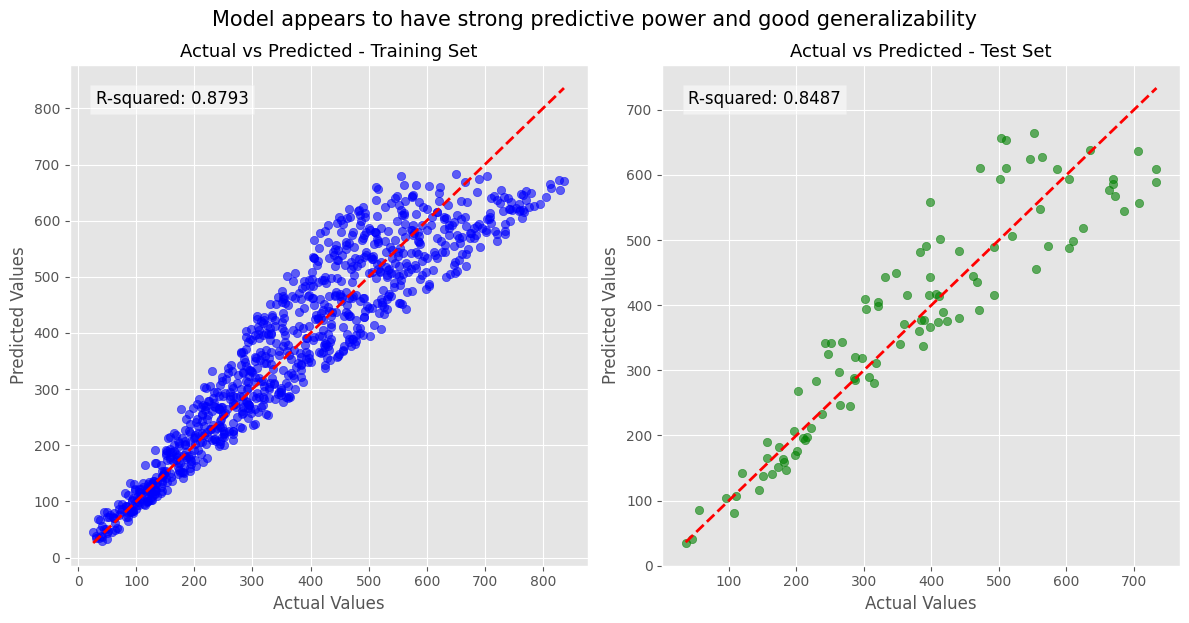

In [68]:
# fit final regressor to train set
final_regressor.fit(X_train, y_train)

# predict the target variable for training and test sets
y_train_pred = final_regressor.predict(X_train)
y_test_pred = final_regressor.predict(X_test)

# compute R-squared
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# plot actual vs predicted on training set
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted - Training Set', size=13)
plt.grid(True)
plt.text(0.05, 0.95, f'R-squared: {r2_train:.4f}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# plot actual vs predicted on test set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted - Test Set', size=13)
plt.grid(True)
plt.text(0.05, 0.95, f'R-squared: {r2_test:.4f}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.suptitle('Model appears to have strong predictive power and good generalizability', y=1.03, size=15)
plt.show()

**Note**
- In general both plots show good performance of Lasso Regression model on training and testing sets.
- The plot on the left shows a high $R^2$ value. This suggests that the model fits the training data well.
- The plot on the right displays a slightly lower $R^2$, implying the the model stilll has good performance on unseen data but slightly less accurate compared to the training set. 

#### **5.2.3 Residual Plot on Training Data**
Residual plot basically a way to diagnose the performance of a regression model. From this plot, it is possible to evaluate whether the relationship between the set of predictors and the target variable, namely `HistoricalCostofRide` is linear. Linearity can be seen only of the residuals are scattered around the zero. If the residuals display a curve either downward or upward, the relationship is non-linear. Another point to aseess is whether the residuals are normally distributed. Similar what has been done previously in Section 2.2, normality can be either checked numerically or visually. And if either of the tests display non-normal distribution in the residuals, the model's predictions may not be accurate because the non-normal distribution indicates that the model does not accurately reflect the true relationship between the predictors and the target variable.

**How do the residuals look like?**

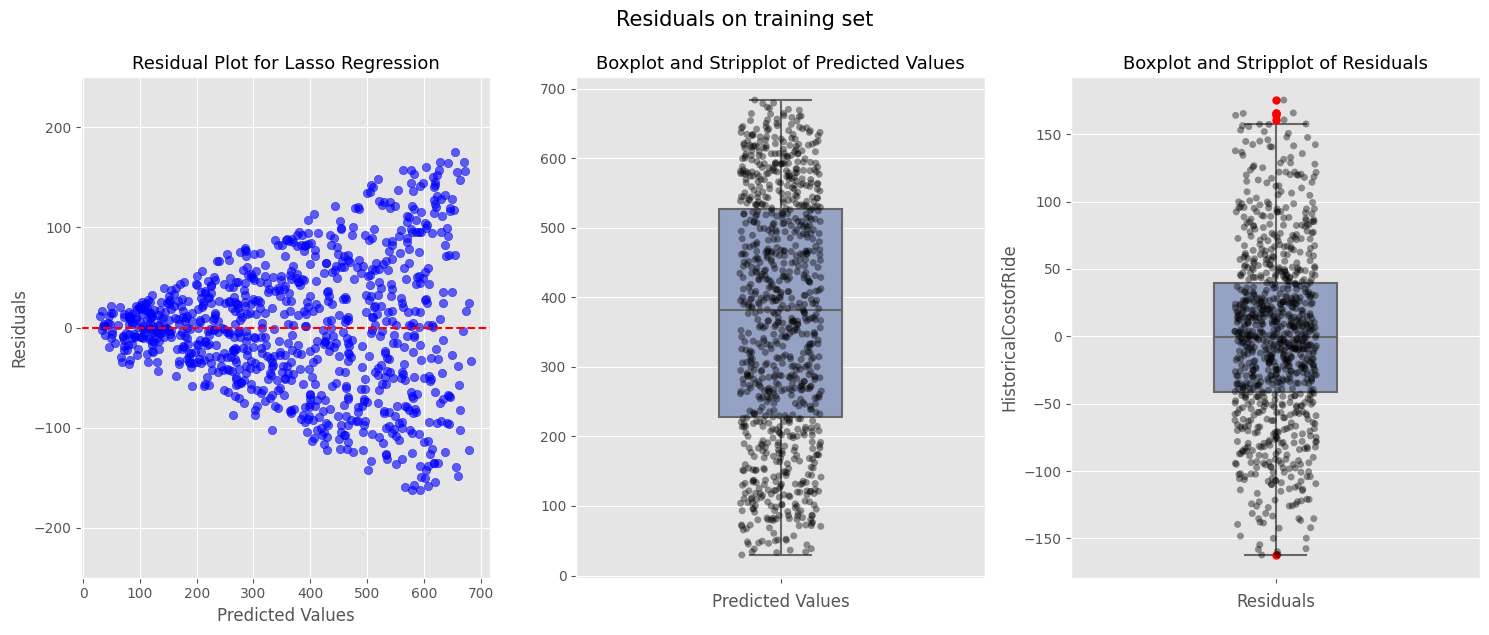

In [69]:
# predict the target variable and compute residuals
y_train_pred = final_regressor.predict(X_train)
residuals = y_train - y_train_pred

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# residual plot
axes[0].scatter(y_train_pred, residuals, color='blue', alpha=0.6)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residual Plot for Lasso Regression', size=13)
axes[0].grid(True)
axes[0].set_ylim(-250, 250)

# boxpot of predicted values
sns.boxplot(y=y_train_pred, ax=axes[1], color='#8e9fca', width=0.3, 
            flierprops=dict(marker='.', markeredgecolor='red', alpha=1))  
sns.stripplot(y=y_train_pred, ax=axes[1], color='black', alpha=0.4)
axes[1].set_xlabel('Predicted Values')
axes[1].set_title('Boxplot and Stripplot of Predicted Values', size=13)

# boxplot of residuals
sns.boxplot(y=residuals, ax=axes[2], color='#8e9fca', width=0.3, 
            flierprops=dict(marker='.', markerfacecolor='red', 
                            markeredgecolor='red', alpha=1, markersize=10))  
sns.stripplot(y=residuals, ax=axes[2], color='black', alpha=0.4)
axes[2].set_xlabel('Residuals')
axes[2].set_title('Boxplot and Stripplot of Residuals', size=13)

plt.tight_layout()
plt.suptitle('Residuals on training set', size=15, y=1.05)
plt.show()

**Note**
- The residuals are scattered around the dashed red line in the center. This suggests that the model's predictions are generally not biased and no obvious patterns in errors as well. Because they are centered around zero, the model's predictions are also reasonably accurate for the majority data points.
- However, the spread of the residuals appear to have a funnel shape, meaning that the model suffers from heteroscedasticity. Heteroscedasticity is shown by the spread of resuiduals which increase as the predicted values increase. To confirm this problem, a further test can be conducted.
- The predicted values are roughly summetric. This indicates that the model is consistent in its predictions.
- The residuals show that the most residuals are small in magnitude with a few outliers (see the red dots and outlier detection below). This implies that the model's errors are generally small and evenly distributed.

In [70]:
# get descriptive statistics
residuals.describe().to_frame().round(4).transpose()

,count,mean,std,min,25%,50%,75%,max
HistoricalCostofRide,900.0,-0.0,65.4488,-162.2835,-41.1317,-0.4758,39.5668,175.3696


In [71]:
# get Q1, Q3, and IQR
Q1 = residuals.quantile(0.25)
Q3 = residuals.quantile(0.75)
IQR = Q3 - Q1

# get thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# detect outliers
outliers = residuals[(residuals < lower_bound) | (residuals > upper_bound)]
print(f'{len(outliers)} Outliers detected:')
display(outliers.to_frame())

6 Outliers detected:


,HistoricalCostofRide
689,165.820108
904,165.464900
629,160.661873
757,164.057538
742,-162.283487
805,175.369625


**Does the model suffer from heteroscedasticity?**

In [103]:
# get predictions from the regressor
preprocessor = final_regressor.named_steps['preprocessor']
regressor = final_regressor.named_steps['regressor']
X_train_transformed = preprocessor.transform(X_train)

# add constant to the transformed features
X_train_transformed_with_const = sm.add_constant(X_train_transformed)

# Breusch-Pagan Test
bp_test_statistic, bp_p_value, _, _ = het_breuschpagan(residuals, X_train_transformed_with_const)
print(f'Breusch-Pagan test p-value: {bp_p_value:.4f}')

Breusch-Pagan test p-value: 0.0000


**Note**
- Breusch-Pagan test is a way of evaluating heteroscedasticitty in residuals. This test checks whether the residuals have constant variance or not. If the *p*-value of the test is lower than 0.05, heteroscedasticity is present in the residuals.
- Based on the output above, the model suffers from heteroscedasticity (unequal variance) with *p* < 0.05. While this heteroscedasticity affects the accuracy of the model's predictions, this problem should be test further.
- I need to understand whether this heteroscedasticity poses a big problem or not on the model. To test this, I will need to compute the variance of the residuals. But it is impossible to evaluate the residual variance when there is no baseline to determine whether the variance is substantial or not. This baseline variance provides a referecne point for evaluating the magnitude of residual variance.

In [73]:
# calculate residual variance
residual_variance = np.var(residuals)
print("Residual variance:", round(residual_variance, 2))

Residual variance: 4278.78


In [74]:
# compute baseline residual variance
baseline_predictions = np.mean(y_train)
baseline_residuals = y_train - baseline_predictions
baseline_residual_variance = np.var(baseline_residuals)
print(f"Baseline residual variance: {baseline_residual_variance:.2f}")

Baseline residual variance: 35441.54


**Note**: The baseline residual variance is 35,441.54 while the residual variance is 4,278.78. This result means that the residual variance is much smaller. For this reason, the model remains effective i explaining the variance in the target variable despite the presence of heteroscedasticity.

#### **5.2.4 Best Model's Learning Curve**
Learning curve plot evaluates how the model's perform as the training data size increases. As can be seen below, there are two lines: red and green. The red line represents training scores and the green one represents the cross-validation scores. The expected output is that the gap between green and red lines is narrow, signaling no substantial difference between the training scores and cross-validation scores. When there in no significant difference in both scores, the model does not suffer from an overfitting problem.

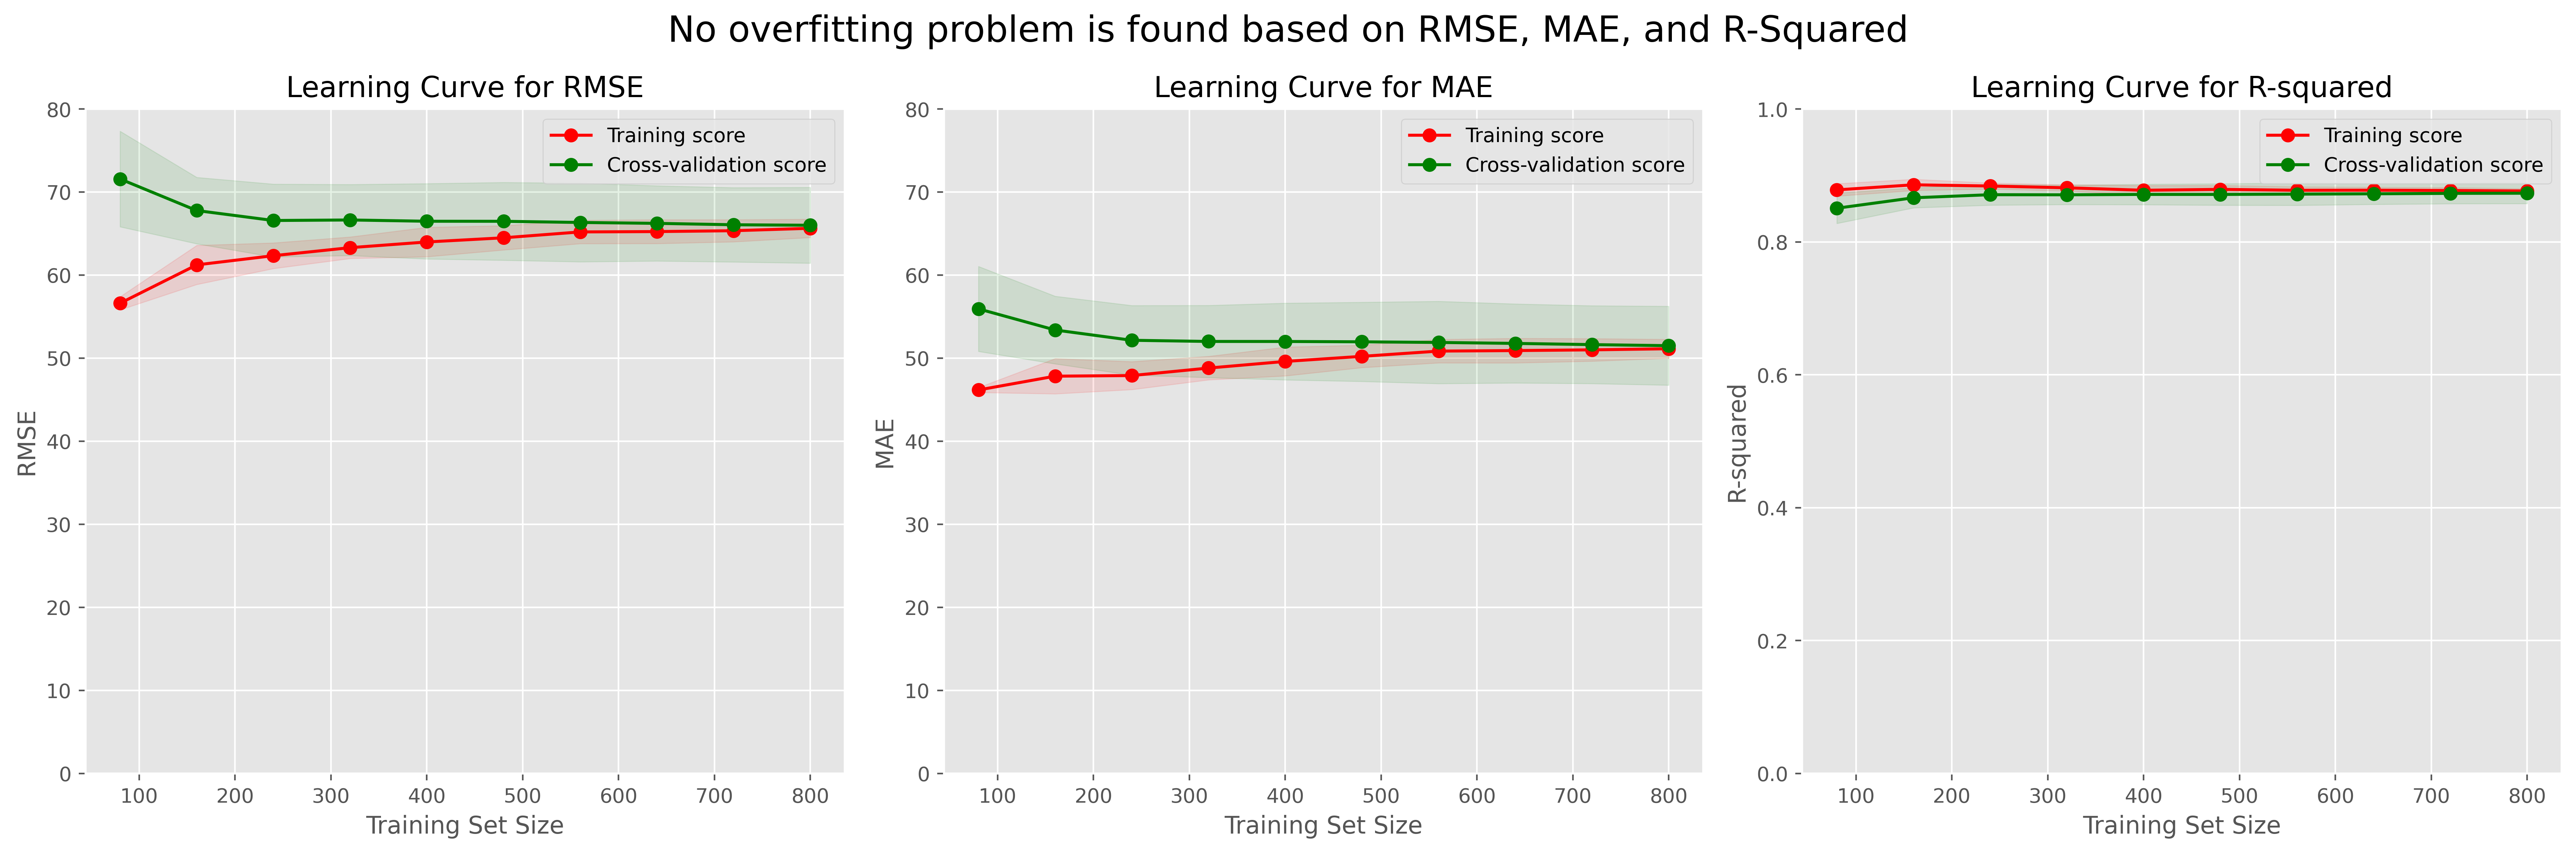

In [75]:
# metrics to plot
metrics = {
    'RMSE': 'neg_root_mean_squared_error',
    'MAE': 'neg_mean_absolute_error',
    'R-squared': 'r2'
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=400)
for ax, (metric_name, scoring) in zip(axes, metrics.items()):
    # generate the learning curve for each metric
    train_sizes, train_scores, test_scores = learning_curve(
        final_regressor, X, y, cv=5, scoring=scoring, 
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    
    # calculate mean and SD for training and test scores
    if 'neg' in scoring:
        train_scores_mean = -train_scores.mean(axis=1)
        test_scores_mean = -test_scores.mean(axis=1)
    else:
        train_scores_mean = train_scores.mean(axis=1)
        test_scores_mean = test_scores.mean(axis=1)
        
    train_scores_std = train_scores.std(axis=1)
    test_scores_std = test_scores.std(axis=1)
    
    # plot the learning curve for the current metric
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    ax.set_title(f"Learning Curve for {metric_name}")
    ax.set_xlabel("Training Set Size")
    ax.set_ylabel(metric_name)
    ax.legend(loc="best")
    ax.grid(True)
    
    # set specific y-axis limits based on the metric
    if metric_name in ['RMSE', 'MAE']:
        ax.set_ylim(0, 80)
    elif metric_name == 'R-squared':
        ax.set_ylim(0, 1)

plt.suptitle('No overfitting problem is found based on RMSE, MAE, and R-Squared', size=18)
plt.tight_layout()
plt.show()

**Note**
- The scores stabilize as the training set size increases, indicating the model's performance becomes more consistent with more data.
- As shown, the gaps between training scores and cross-validation scores in the three metrics are relatively small. This finding indicates the model does not suffer from overfitting and good generalization capability (narrow gaps).

#### **5.2.5 Best Model's Under and Overpredictions**
In section 5.2.3, I have demonstrated how the final model accurately predict fares of ride sharing on the training set. Here, I will show how the model makes predictions on the test set by exploiting its residuals (differences between actual and predicted values), especially related to under and overpredictions. Firstly, I will revisit the comparison between actual and predicted values using a scatter plot along with a boxplot of residuals to check the overall performance of the final model on unseen data. Afterwards, I will display in when the model performs not really well on the test set.

**General overview on the testing set**

In [76]:
# make predictions and compute residuals
y_test_pred = final_regressor.predict(X_test)
residuals_test = y_test - y_test_pred

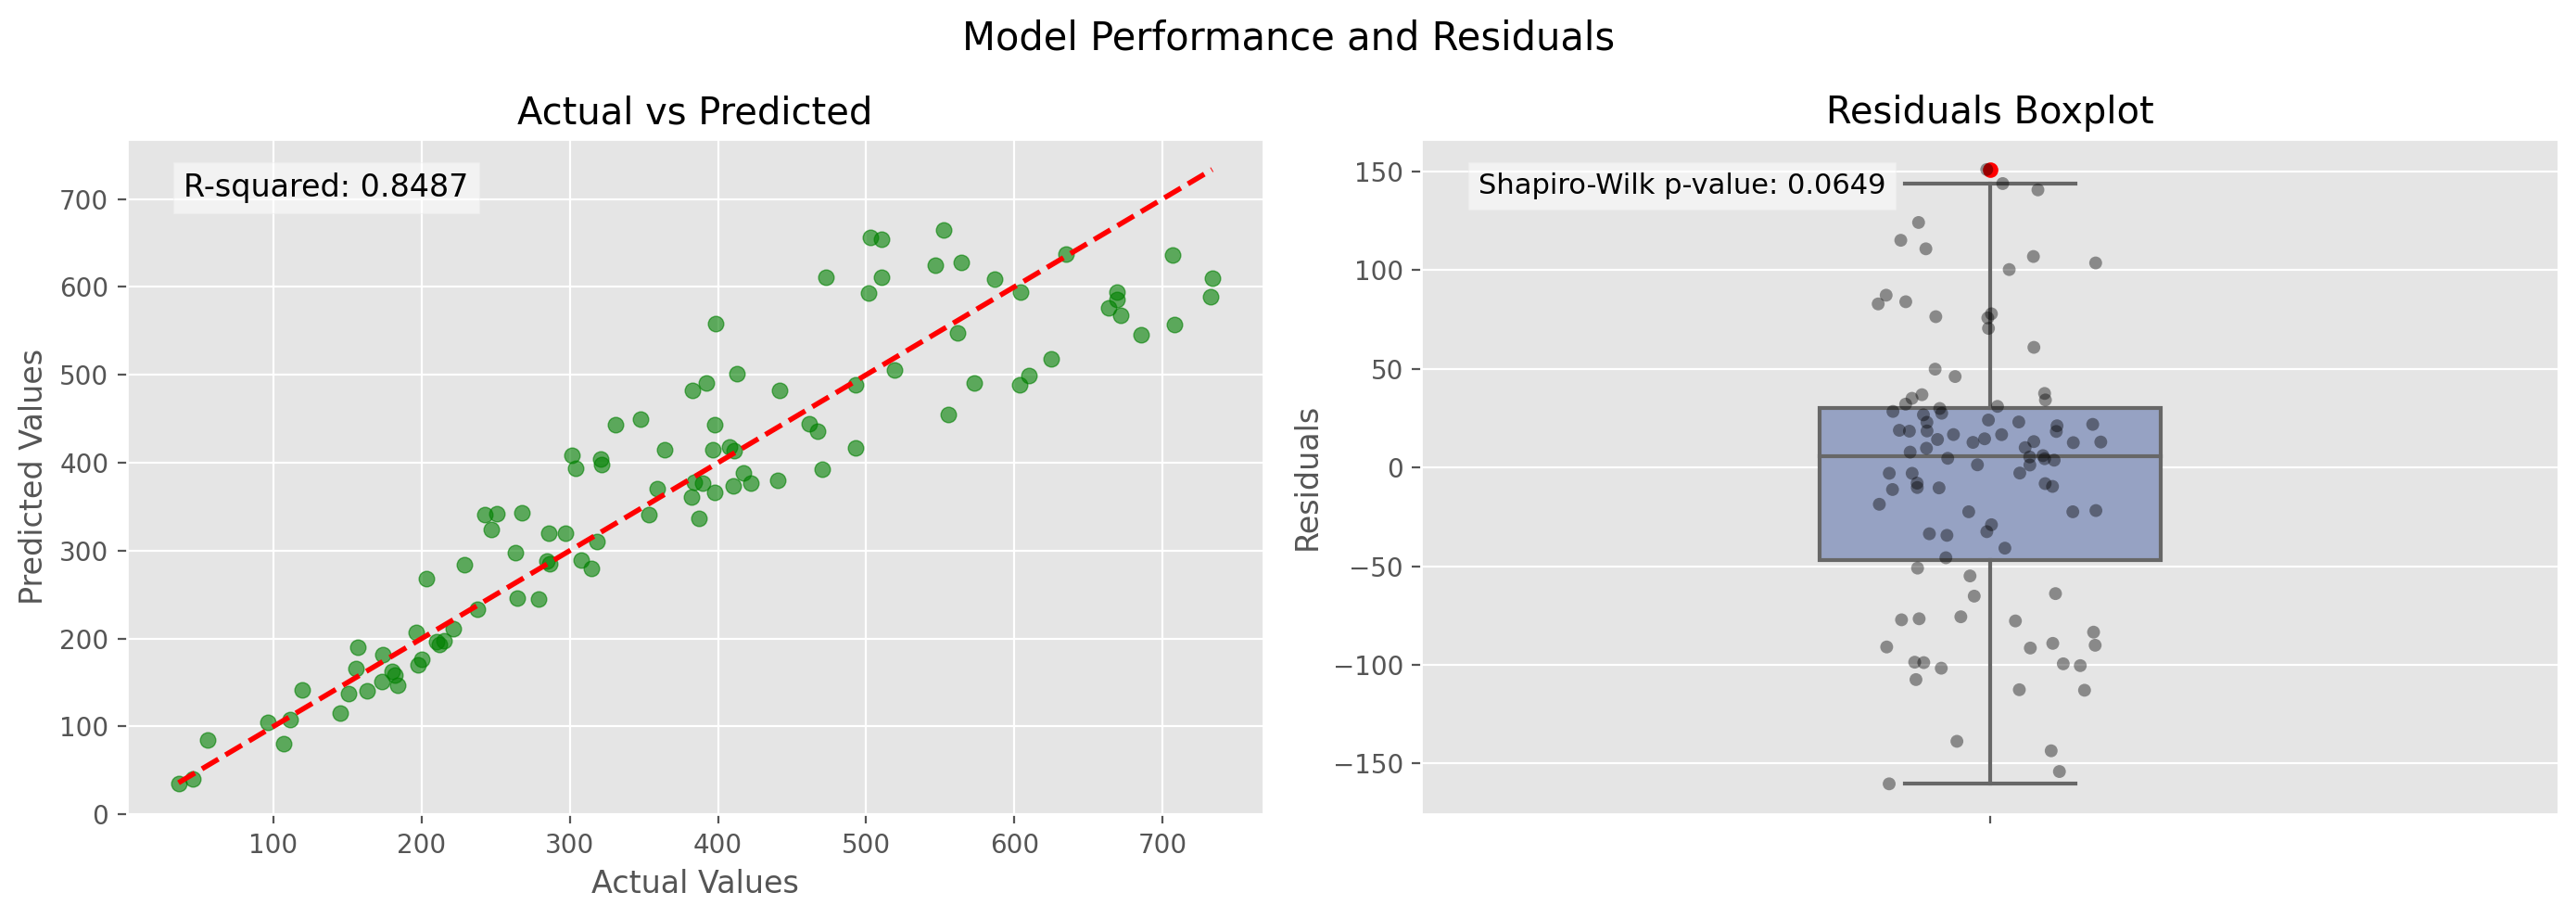

In [77]:
# create figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=200)

# the actual vs predicted values
axes[0].scatter(y_test, y_test_pred, color='green', alpha=0.6)
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].set_title('Actual vs Predicted')
axes[0].grid(True)
axes[0].text(0.05, 0.95, f'R-squared: {r2_test:.4f}', transform=axes[0].transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# residuals
sns.boxplot(y=residuals_test, ax=axes[1], color='#8e9fca', width=0.3, 
            flierprops=dict(marker='.', markerfacecolor='red', 
                            markeredgecolor='red', alpha=1, markersize=10))  
sns.stripplot(y=residuals_test, ax=axes[1], color='black', alpha=0.4)
axes[1].set_title('Residuals Boxplot')
axes[1].set_ylabel('Residuals')

# Shapiro-Wilk test for normality
shapiro_stat, shapiro_p_value = shapiro(residuals_test)

# Annotate the boxplot with Shapiro-Wilk test results
axes[1].text(0.05, 0.95, f'Shapiro-Wilk p-value: {shapiro_p_value:.4f}', 
             transform=axes[1].transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.5))

plt.suptitle('Model Performance and Residuals', size=15)
plt.tight_layout()
plt.show()

**Note**
- Scatter plot: Relationship between actual and predicted fares
    - The scatter plot shows a strong positive correlation between actual and predicted values as indicated by the closely clustered data points around the red dashed line (perfect correlation line).
    - The high $R^2$ value suggests that $\approx$ 85% of the variability in the actual values is explained by the model. This score indicates a good fit.
- Boxplot: Distribution of the residuals
    - The boxplot shows that the difference between actual and predicted fares is centered around zero, and relatively symmetrical. This relative symmetry indicates that the erros are distributed evenly around the zero.
    - Additionally, with a p-value of 0.0649, the residuals can be considered approximately normally distributed.
    - However, some outliers are present in the residuals as shown by the red dot. And after a quick check (see below), the residuals only contain one outlier when detected using interquartile range.

In [78]:
# get Q1, Q3, and IQR
Q1 = residuals_test.quantile(0.25)
Q3 = residuals_test.quantile(0.75)
IQR = Q3 - Q1

# get thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# detect outliers
outliers = residuals_test[(residuals_test < lower_bound) | (residuals_test > upper_bound)]
print(f'{len(outliers)} outliers detected:')
print(round(outliers, 2))

1 outliers detected:
764    150.87
Name: HistoricalCostofRide, dtype: float64


**How big are the under and overpredictions made by the final model?**

After understanding an overall performance of the model in making predictions, I will proceed checking the magnitude of residuals on the testing data further. Investigating the differences between actual and predicted fares will provide a better understanding of when the model makes unreliable predictions in the testing data. Therefore, the results may guide the model users when making business decisions, particularly whether or not using the model's predictions. 

In [79]:
# combine X_test and y_test
prediction_df = pd.concat([X_test, y_test], axis=1)
prediction_df['HistoricalCostofRide'] = prediction_df['HistoricalCostofRide'].round(2)
# make prediction on X_test
prediction_df['PredictedPrice'] = final_regressor.predict(X_test).round(2)
# compute residuals
prediction_df['Residual'] =  prediction_df['HistoricalCostofRide'].round(2) - prediction_df['PredictedPrice'].round(2)
prediction_df['PredictionStatus'] = prediction_df['Residual'].apply(lambda x: 'Overprediction' if x > 0 else 'Underprediction')
prediction_df.loc[:, 'HistoricalCostofRide':'PredictionStatus'].head()

,HistoricalCostofRide,PredictedPrice,Residual,PredictionStatus
521,470.27,392.49,77.78,Overprediction
737,286.41,285.10,1.31,Overprediction
740,552.27,664.87,-112.60,Underprediction
660,267.74,343.40,-75.66,Underprediction
411,111.11,107.46,3.65,Overprediction


In [80]:
# subset df into under and overprediction
underprediction_df = prediction_df[prediction_df['PredictionStatus'] == 'Underprediction']
overprediction_df = prediction_df[prediction_df['PredictionStatus'] == 'Overprediction']

# print results
print(f'Out of {len(prediction_df)}, the model made:')
print(f'- Underpredictions: {len(underprediction_df)}')
print(f'- Overpredictions: {len(overprediction_df)}')

Out of 100, the model made:
- Underpredictions: 44
- Overpredictions: 56


**Note**
- Analyzing residuals can provide an understanding of the model's performance and reliability. The analysis can particularly be carried out by checking the manitude of the residuals. If the residuals are large, the model make significant errors in its prediction. This condition means that the model is not a good fit for the data. But if the residuals are small, the model can accurately capture the relationship between features and target variable.
- As shown on the output above, out of 100 predictions, the model makes 44 underpredictions and 56 overpredictions. Here, under and overpredictions are defined by the magnitude of the residuals below or above zero.
- The magnitude of under or overpredictions will be examined further below.

In [81]:
# get descriptive stats
prediction_df[['Residual']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Residual,100.0,-3.0617,68.71751,-160.26,-47.07,5.625,30.0975,150.87


In [82]:
stat, p_value = shapiro(prediction_df['Residual'])

print('W = %.3f, p = %.3f' % (stat, p_value))
if p_value > 0.05:
    print('Residuals look normally distributed (fail to reject H0)')
else:
    print('Residuals do not look normally distributed (reject H0)')


W = 0.976, p = 0.065
Residuals look normally distributed (fail to reject H0)


**Note**
- To judge whether a particular residual is large or not, I need to check the distribution. The distribution gives a numerical sense to operate "big" in the analysis of residuals. 
- And from the descriptive statistics, how big a residual is can be defined at least in two ways: (1) below and above 25% and 75% percentiles, and (2) 2x standard deviations from the mean.
- If using the percentile-based thresholds, there will be too many residuals detected as "big". For this reason, I will operate "big residual" using 2x SD. This threshold provides a balance between flaging too many residuals and missing outliers. Moreover, theoretically speaking, in a normal distribution, approx 95% of data falls within $\pm$ 2 SD of the mean. Because the distribution of residuals is normal (*W* = 0.976, *p* = 0.065), I will proceed using 2 x SD to operate "big residual".

In [83]:
threshold = 2 * residuals_test.std()

# to avoid copy warning
underprediction_df = underprediction_df.copy()
overprediction_df = overprediction_df.copy()

# use 4 bins to group underpredictions
underprediction_df['BinnedActualCost'] = pd.cut(underprediction_df['HistoricalCostofRide'], bins=4)
underprediction_report = (underprediction_df.groupby('BinnedActualCost', as_index=False)
                          .agg(func={'Residual':'mean'}).round(2))
underprediction_report['ResidualSize'] = (underprediction_report['Residual']
                                          .apply(lambda x: 'Large Residual' if abs(x) > threshold else 'Small Residual'))
overprediction_df['BinnedActualCost'] = pd.cut(overprediction_df['HistoricalCostofRide'], bins=4)
overprediction_report = (overprediction_df.groupby('BinnedActualCost', as_index=False)
                         .agg(func={'Residual':'mean'}).round(2))
overprediction_report['ResidualSize'] = (overprediction_report['Residual']
                                         .apply(lambda x: 'Large Residual' if abs(x) > threshold else 'Small Residual'))

# display output
print('Underpredictions:')
display(underprediction_report)
print('Overpredictions:')
display(overprediction_report)

Underpredictions:


,BinnedActualCost,Residual,ResidualSize
0,"(55.061, 200.413]",-17.15,Small Residual
1,"(200.413, 345.185]",-68.43,Small Residual
2,"(345.185, 489.958]",-66.85,Small Residual
3,"(489.958, 634.73]",-85.39,Small Residual


Overpredictions:


,BinnedActualCost,Residual,ResidualSize
0,"(35.303, 210.36]",19.04,Small Residual
1,"(210.36, 384.72]",15.86,Small Residual
2,"(384.72, 559.08]",41.82,Small Residual
3,"(559.08, 733.44]",94.65,Small Residual


**Note**
- Two dataframes above summarize groups of residuals along with the magnitude of residuals. Here, the residuals are calculated using the mean of each residual group because the distribution of residuals is normal. Mean is a good measure here because it reflects the central tendency of the distribution.
- Let me unpack the first dataframe on the final model's underpredictions. In general, even if the model makes underpredictions, the difference between actual and predicted fares remains small as indicated by column `ResidualSize`. The largest underpredictions happen in the last group in which the actual cost is big (between 489.958 and 634.73). 
- For the second dataframe, the model also still makes small errors (`ResidualSize`) in its overestimations of fares with its largest mean residual when actual cost is between 559.08 and 733.44.
- Taking them altogether, the small residuals in both under and overpredictions imply that the model's predictions remain reliable for business.

In [84]:
# detect outliers in all predictions
detect_outliers(prediction_df, 'Residual')

# detect outliers in subsetted prediction dfs
detect_outliers(underprediction_df, 'Residual')
detect_outliers(overprediction_df, 'Residual')

The number of outliers in 'Residual' is 1 or 1.00% of the total data (100 rows).
The number of outliers in 'Residual' is 0 or 0.00% of the total data (44 rows).
The number of outliers in 'Residual' is 0 or 0.00% of the total data (56 rows).


**Note**
- As shown earlier, there is one outlier in the predictions dataframe but when subsetting the dataframe into under and overpredictions, the outliers disappeared.
- Furthermore, as the outlier is only one, and does not affect much on the distribution of residuals on the testing set, this outlier can be ignored as the model's predictions remain trustworthy based on the small magnitude of residuals.

### **5.3 Best Model's Explainability (XAI)**
#### **5.3.1 Best Model's Feature Importance**
Feature importance is a way of evaluating the model's predictions by breaking down each feature's contribution in the predictions. Generally, an evaluation of feature importance on the model's predictions should be adapted from the inner workings of the model when making predictions. For example, tree-based models such as Random Forest, Gradient Boosting, and XGBoost, rely on gini importance (mean decrease in impurity) to generate feature importance. Other example is Gaussian Naive Bayes model which uses conditional probabilities. For this reason, Gaussian Naive Bayes model's predictions are usually evaluated using permutation importance of feature. 

However, since the final model here is Lasso Regression, the evaluation of model's predictions can be straightforward, utilizing the coefficient of each feature trained on the model.

In [85]:
coefficients = final_regressor.named_steps['regressor'].coef_
transformed_feature_names = final_regressor.named_steps['preprocessor'].get_feature_names_out()
feature_importance = pd.DataFrame({
    'Feature': transformed_feature_names,
    'Importance': coefficients
})

# sort by absolute importance
feature_importance['Absolute_Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='Absolute_Importance', ascending=False)

# drop 'Absolute_Importance'
feature_importance.drop(columns=['Absolute_Importance'], inplace=True)

# display feature importance
display(feature_importance)

,Feature,Importance
4,num_scaling__ExpectedRideDuration,291.119049
15,categorical__VehicleType_Economy,-41.922190
1,num_scaling__NumberofDrivers,9.570871
3,num_scaling__AverageRatings,2.558540
12,categorical__TimeofBooking_Evening,-0.545305
0,num_scaling__NumberofRiders,-0.000000
10,categorical__CustomerLoyaltyStatus_Silver,0.000000
14,categorical__TimeofBooking_Night,-0.000000
13,categorical__TimeofBooking_Morning,0.000000
11,categorical__TimeofBooking_Afternoon,0.000000


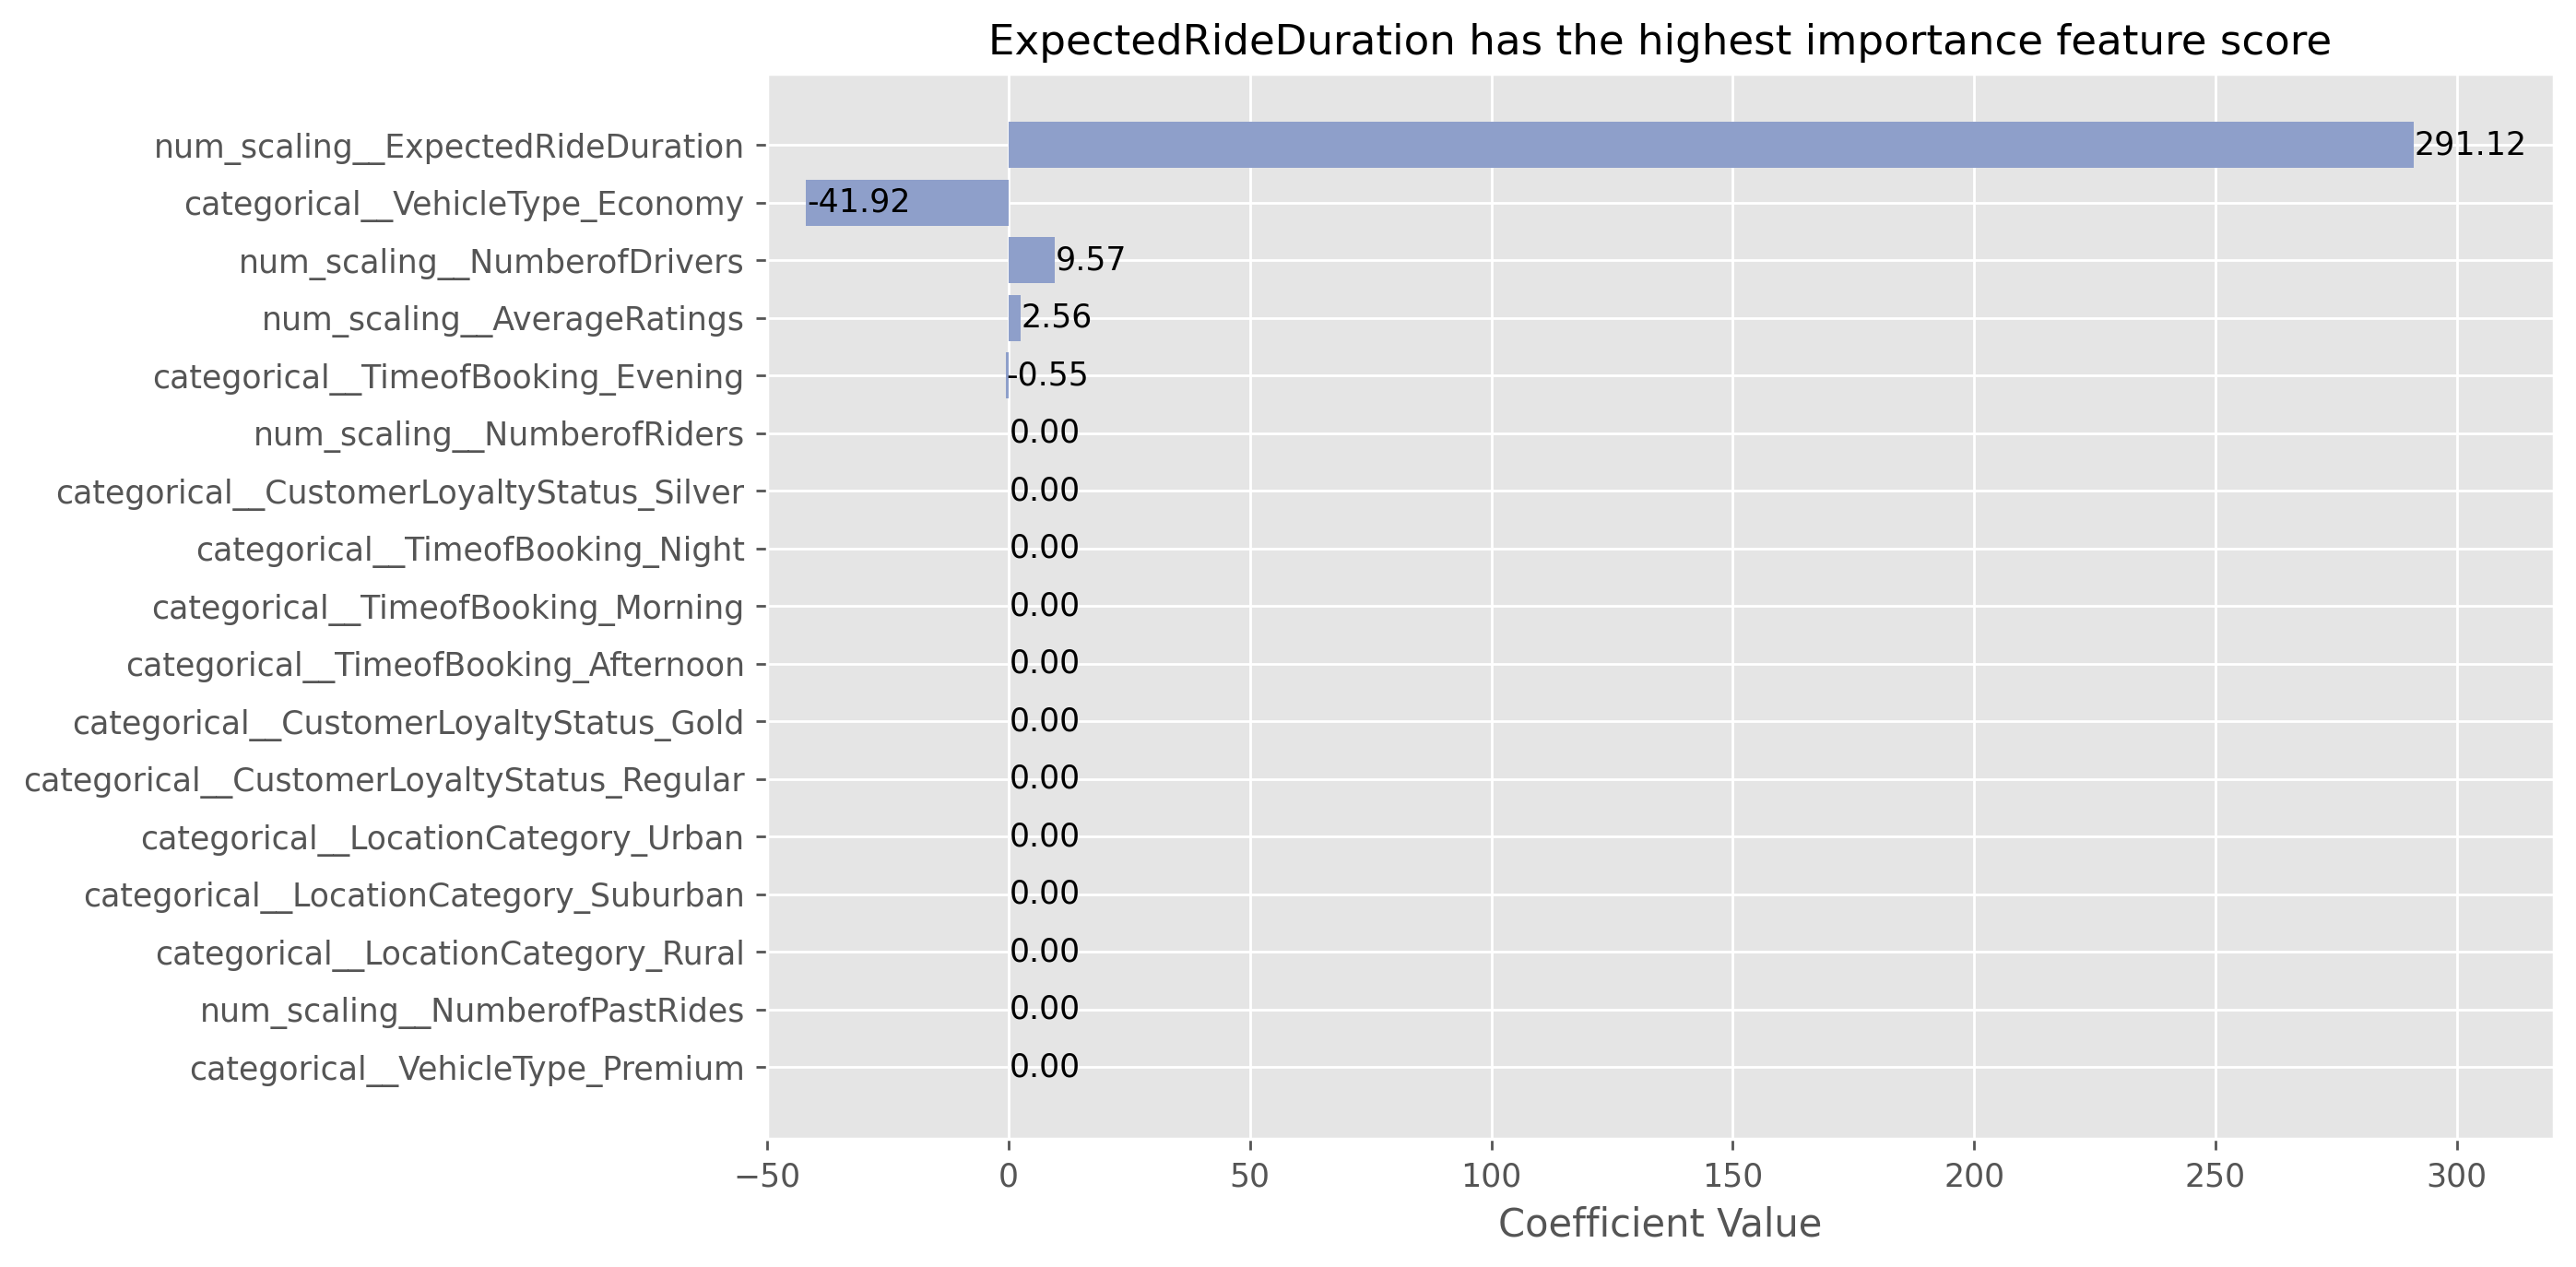

In [86]:
# visualize feature importance
plt.figure(figsize=(10, 6), dpi=250)
bars = plt.barh(feature_importance['Feature'].head(20), feature_importance['Importance'].head(20), color='#8e9fca')

# add data labels 
for bar in bars:
    plt.text(
        bar.get_width() + 0.1,                  # position slightly to the right of the bar end
        bar.get_y() + bar.get_height() / 2,     # vertical position at the center of the bar
        f'{bar.get_width():.2f}',               # format the coefficient value to 2 decimal places
        va='center',                            # vertical alignment
        ha='left',                              # horizontal alignment
        fontsize=10,                            
        color='black'                           
    )

plt.xlabel('Coefficient Value')
plt.title('ExpectedRideDuration has the highest importance feature score', size=13)
plt.gca().invert_yaxis()                        # show the highest coefficients at the top
plt.xlim(-50, 320)
plt.show()

**Note**
- `num_scaling_ExpectedRideDuration` has the highest positive coefficient (291.13), indicating that longer expected ride durations significantly increase the predicted price.
- `categorical_VehicleType_Economy` has a negative coefficient (-41.74), suggesting that using economy vehicles decreases the predicted price.
- `num_scaling_NumberOfDrivers` has a positive coefficient (9.56), meaning more drivers slightly increase the predicted price.
- Many features have zero (or near-zero) coefficient. This condition means that they do not contribute significantly to the model's predictions.

#### **5.3.2 Global Explanation: General Behavior of the Model**
While feature importance has explain the model's general behavior, Shapley Additive Explanation (SHAP) summary plot adds more information, especially concerning how feature values contributes positively or negatively to the predictions. To interpret the plot, let me clarify the component of this plot first. The $x$ axis shows the impact of a feature on the model's prediction using SHAP values. In brief, positive values increase the predicted price, and the negative ones will decrease the predicted price. On the $y$ axis, the features trained on the model are shown.

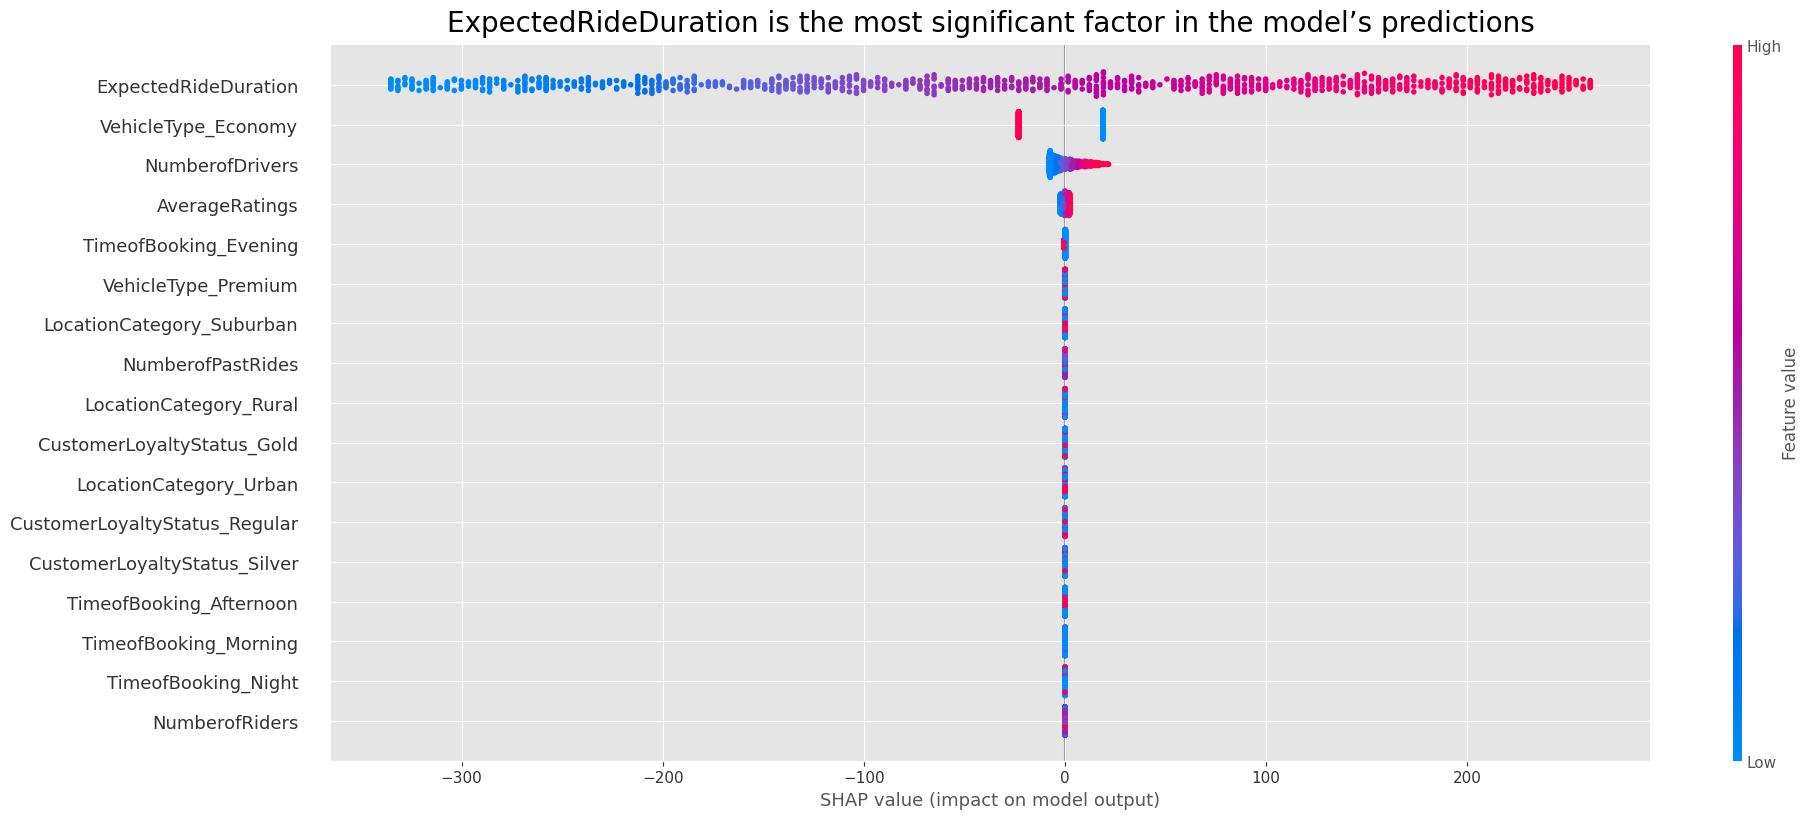

In [87]:
# function to generate feature names
def get_feature_names(preprocessor):
    # extract numerical feature names
    numeric_features = preprocessor.named_transformers_['num_scaling'].named_steps['scaling'].get_feature_names_out()
    # extract categorical feature names
    categorical_features = preprocessor.named_transformers_['categorical'].named_steps['cat'].get_feature_names_out()
    # combine feature names
    all_feature_names = list(numeric_features) + list(categorical_features)
    return all_feature_names

# get feature names
feature_names = get_feature_names(final_regressor.named_steps['preprocessor'])
# transform X_train using final pipeline
X_train_processed = final_regressor.named_steps['preprocessor'].transform(X_train)
# init the SHAP with the model
explainer = shap.LinearExplainer(final_regressor.named_steps['regressor'], X_train_processed)
# calculate SHAP values
shap_values = explainer.shap_values(X_train_processed)
# plot SHAP summary
shap.summary_plot(shap_values, X_train_processed, feature_names=feature_names, plot_size=(20, 8), show=False)
plt.title('ExpectedRideDuration is the most significant factor in the model’s predictions', size=20, pad=10)
plt.show()

**Note**
- `ExpectedRideDuration` has the highest impact on the model’s predictions. Higher values (red points) increase the predicted price, while lower values (blue points) decrease it.
- `VehicleType_Economy` has a notable impact on the model's predictions on ride sharing cost too. As can be seen, higher values in the feature (red) lead to lower predicted price.
- `NumberOfDrivers` and `AverageRatings` have a moderate impact on the predicted price duration. And the rest features seem to have a smaller to no impact on the predicted price.
- Based on these insights, expected ride duration can be considered as a primary basis for dynamic pricing.

#### **5.3.3 Local Explanation: Prediction on the Instance Level**

In [88]:
# combine X_train and y_train
train_data = pd.concat([X_train, y_train], axis=1)

# transpose for better display
train_data.iloc[[0], :].transpose().reset_index().rename(columns={716:'value'})

,index,value
0,NumberofRiders,53
1,NumberofDrivers,17
2,LocationCategory,Rural
3,CustomerLoyaltyStatus,Silver
4,NumberofPastRides,78
5,AverageRatings,4.03
6,TimeofBooking,Afternoon
7,VehicleType,Premium
8,ExpectedRideDuration,26
9,HistoricalCostofRide,120.247193


In [89]:
# init SHAP explainer
explainer = shap.LinearExplainer(final_regressor.named_steps['regressor'], 
                                 final_regressor.named_steps['preprocessor'].transform(X_train))

# compute SHAP values for the training data
shap_values = explainer.shap_values(final_regressor.named_steps['preprocessor'].transform(X_train))

# select an instance 
instance_index = 0 
instance_shap_values = shap_values[instance_index]

# plot the SHAP values for the selected instance
shap.initjs()
shap.force_plot(explainer.expected_value, instance_shap_values, 
                final_regressor.named_steps['preprocessor'].transform(X_train)[instance_index], 
                feature_names=final_regressor.named_steps['preprocessor'].get_feature_names_out())

**Note**
- This plot displays the impact of each feature on the model's prediction in the individual instance level.
- The model's prediction on the first instance is influenced more by two features which each of them has contradictory impact on the model's prediction.
    - `ExpectedRideDuration` has a negative SHAP value. This indciates that it decreases the model's prediction. The blue coloe suggests that a lower expected duration is associated with lower predictions.
    - `VehicleType_Economy` has a positive SHAP value, indicating positive contribution to the model's prediction. The red color shows that this specific category of vehichle and economy level is associated with higher prediction.

#### **5.3.4 Simulation with ExpectedRideDuration**
Because the most significant factor in the prediction is `ExpectedRideDuration`, the simulation here will demonstrate the profitability of the ride sharing services when the ride duration increases, for instance, when the marketing team performs a promotional campaign in order customers to extend their duration by at least 20%.

In [90]:
X_test_modified = X_test.copy()

# simulate the effect of the campaign by increasing ExpectedRideDuration by 20%
X_test_modified['ExpectedRideDuration'] *= 1.20
predicted_prices_modified = final_regressor.predict(X_test_modified)
profits_modified = predicted_prices_modified - y_test
total_profit_modified = np.sum(profits_modified)

# assume the campaign costs a fixed amount
campaign_cost = 5000  
net_profit_with_campaign = total_profit_modified - campaign_cost
print(f"Total profit with increased expected ride duration: ${total_profit_modified:.2f}")
print(f"Net profit with campaign cost: ${net_profit_with_campaign:.2f}")

Total profit with increased expected ride duration: $7403.88
Net profit with campaign cost: $2403.88


**Note**: Assuming the marketing campaign cost USD 5,000, the company will received profit of USD 7,403.88, or net profit of USD 2,403.88. Since this simulation is done on the testing set, the net profit seems small. This profit will increase as the number of customers increase.

### **5.4 Model Saving**

In [91]:
joblib.dump(final_regressor, '../model/final_model.pkl')
print('Model saved!')

Model saved!


## **6 Conclusions and Recommendations**
### **6.1 Conclusions**
A ride sharing company currently uses a manual pricing strategy that incorporates time-based pricing and vehicle type considerations, based on exploratory data analysis (EDA). The company is now exploring a dynamic pricing strategy using a machine learning solution to reduce manual efforts. This project aims to develop a dynamic pricing model for ride sharing services. The model was developed through experiments with 12 machine learning algorithms (including linear-based, distance-based, and tree-based methods) and evaluated under three conditions: no treatment, feature selection, and polynomial expansion. The final model was assessed using three performance metrics: R-squared, Mean Absolute Error (MAE), and Root Mean Square Error (RMSE), with a primary focus on RMSE to address substantial errors. Lasso Regression emerged as the best-performing model, exhibiting the smallest errors in RMSE and MAE and the highest R-squared value. The evaluation also confirms that, consistent with EDA findings, ride duration and vehicle types are the most influential factors in determining dynamic pricing.

### **6.2 Recommendations**
#### **6.2.1 Recommendations for Pricing Manager**
- Transition from the current manual pricing strategy to the dynamic pricing model developed using machine learning. This usage will streamline pricing process and reduce manual effort. And as previously mentioned, ride durations and vehicle types are the most influential factors in the model so more focus can be given to these factors.
- Implement iterative testing and validation to ensure the model adaps to market changes and maintain its performance over time. 
#### **6.2.2 Recommendations for Future Development**
- While robust scaling was applied to the training data in the pipeline, robust scaling theoretically does not remove the outliers. Robust scaling only reduces the effect of outliers. Robust scaling involves subtracting the median of each data point and then dividing the output by the interquartile range. This rescaling technique only changes the relative magnitude of each value. In the future development, a winsorization technique can be an option to handle the outliers given the small proportion outliers. This technique should not change the distribution shape significantly when the proportion of outliers to the overall data is small. 
- This project already involved 3 different experiments with different experimental setups. Experiment 1 included 12 algorithms from three different groups which were used to see how well each algorithm with respect to their groups learn patterns from the data. Experiment 2 exploited feature selection to find out how many features are most optimal when training a model. Experiment 3 seeks to understand how polynomial expansion can be used to improve the model's performance by making some interaction terms between features which are useful to understand the interaction effects of multiple features. However, some areas are left. For example, in terms of model, this project has not involved Huber Regressor which is less sensitive to outliers. This model might be useful because there are some outliers in the training data despite small portion. Additionally, a model calibration can also be done to improve the predictive accuracy of the model. The calibration can reduce bias in predictions. 

### **6.3 Project Limitations**
- **Training data**: This project only involves a limited number of features (specified in Section 2) for building a dynamic pricing model. While the dynamic can still make predictions, the predictions are only reliable when the inputted values are within the ranges that have been trained (seen) by the model. 
- **Algorithm**: Lasso is a static model which captures relationship at a specific time point. Dynamic pricing, however, requires time-varying patterns and trends which may not be captured comprehensively by Lasso Regression. For example, in real life, price adapts to situational factor, particularly holiday seasons. During holiday seasons, there might be a substantial increase in demands but this seasonality has not been trained to the model due to the limitation of available data.

## **Reference**
- Field, A., Field, Z., & Miles, J. (2012). *Discovering statistics using R*. SAGE.

<h1 style='text-align:center; color:orange; font-weight:bold'>---END---</h1>

___

In [92]:
# get session info
session_info.show()